=== MINH HỌA THUẬT TOÁN K-MEANS ===
Đã hoàn thành phân cụm với 3 cụm
Độ biến thiên trong cụm (inertia): 518.96
Điểm Silhouette: 0.558


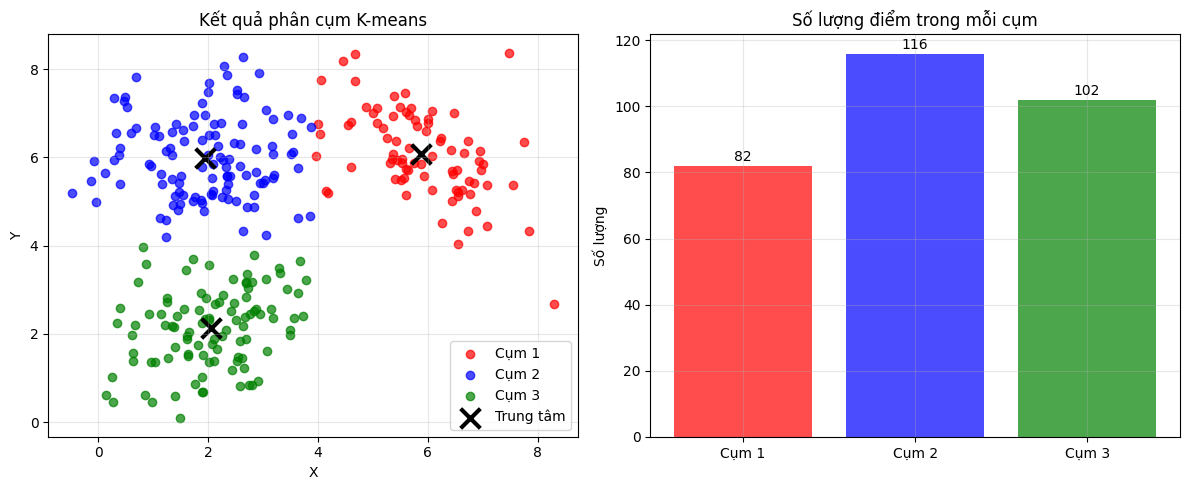

In [1]:
import numpy as np                      # Thư viện xử lý mảng số học
import pandas as pd                     # Thư viện xử lý và phân tích dữ liệu dạng bảng
import matplotlib.pyplot as plt         # Thư viện vẽ đồ thị cơ bản
import seaborn as sns                   # Thư viện vẽ đồ họa thống kê nâng cao
from sklearn.cluster import KMeans      # Thuật toán phân cụm K-means
from sklearn.preprocessing import StandardScaler  # Chuẩn hóa dữ liệu
from sklearn.decomposition import PCA   # Giảm chiều dữ liệu tuyến tính
from sklearn.manifold import TSNE       # Giảm chiều dữ liệu phi tuyến (t-SNE)
from sklearn.cluster import AgglomerativeClustering  # Phân cụm phân cấp
from sklearn.metrics import silhouette_score, adjusted_rand_score  
                                         # Silhouette score: đánh giá chất lượng phân cụm
                                         # Adjusted Rand Index: so sánh nhãn phân cụm với nhãn thật
import warnings
warnings.filterwarnings('ignore')       # Tắt mọi cảnh báo để output gọn gàng

class PhanCumKMeans:
    """
    Lớp thực hiện phân cụm K-means với các tính năng mở rộng:
    - huan_luyen: huấn luyện mô hình và lưu nhãn, tâm cụm, inertia
    - du_doan: gán nhãn cho dữ liệu mới
    - tinh_silhouette_score: đánh giá silhouette
    - ve_ket_qua: trực quan hóa kết quả phân cụm
    """
    
    def __init__(self, n_clusters=3, random_state=42):
        # n_clusters: số cụm K
        # random_state: seed để tái lập kết quả
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = None     # đối tượng KMeans sau khi khởi tạo
        self.labels = None     # mảng nhãn cụm (0..K-1)
        self.centroids = None  # tọa độ các tâm cụm
        self.inertia = None    # tổng khoảng cách vuông đến tâm cụm
        
    def huan_luyen(self, data):
        """
        Huấn luyện mô hình K-means trên dữ liệu:
        - fit_predict: huấn luyện và gán nhãn cùng lúc
        - lưu tâm cụm và inertia
        """
        # Khởi tạo KMeans với n_init=10 (chạy 10 lần với khởi tạo khác nhau, lấy kết quả tốt nhất)
        self.kmeans = KMeans(
            n_clusters=self.n_clusters, 
            random_state=self.random_state,
            n_init=10
        )
        # Huấn luyện và gán nhãn
        self.labels = self.kmeans.fit_predict(data)
        # Lấy tọa độ tâm cụm
        self.centroids = self.kmeans.cluster_centers_
        # Lấy inertia (tổng khoảng cách vuông của điểm đến tâm cụm)
        self.inertia = self.kmeans.inertia_
        
        print(f"Đã hoàn thành phân cụm với {self.n_clusters} cụm")
        print(f"Độ biến thiên trong cụm (inertia): {self.inertia:.2f}")
        
        return self  # cho phép gọi chuỗi như PhanCumKMeans(...).huan_luyen(data)
    
    def du_doan(self, data):
        """
        Dự đoán nhãn cụm cho dữ liệu mới:
        - Kiểm tra đã huấn luyện chưa
        - Trả về mảng nhãn
        """
        if self.kmeans is None:
            raise ValueError("Chưa huấn luyện mô hình")
        return self.kmeans.predict(data)
    
    def tinh_silhouette_score(self, data):
        """
        Tính điểm silhouette để đánh giá:
        - Điều kiện: đã có self.labels
        - silhouette_score: độ tách biệt giữa các cụm (–1..1)
        """
        if self.labels is None:
            raise ValueError("Chưa có kết quả phân cụm")
        return silhouette_score(data, self.labels)
    
    def ve_ket_qua(self, data, feature_names=None):
        """
        Vẽ trực quan kết quả phân cụm:
        - Nếu data >2 chiều, dùng PCA giảm xuống 2D
        - Scatter plot: các điểm theo cụm và tâm cụm
        - Bar chart: số lượng điểm mỗi cụm
        """
        # Cần ít nhất 2 chiều để vẽ scatter
        if data.ndim == 1 or data.shape[1] == 1:
            print("Cần ít nhất 2 đặc trưng để vẽ biểu đồ")
            return
        
        # Giảm chiều nếu >2
        if data.shape[1] > 2:
            pca = PCA(n_components=2)
            data_2d = pca.fit_transform(data)
            print(f"Sử dụng PCA để giảm từ {data.shape[1]} xuống 2 chiều")
            print(f"Tỷ lệ phương sai được giữ lại: {pca.explained_variance_ratio_.sum():.3f}")
        else:
            data_2d = data  # nếu đúng 2 chiều, không cần giảm
        
        plt.figure(figsize=(12, 5))
        
        # --- Biểu đồ phân cụm ---
        plt.subplot(1, 2, 1)
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
        for i in range(self.n_clusters):
            mask = (self.labels == i)  # chọn điểm của cụm i
            plt.scatter(
                data_2d[mask, 0], data_2d[mask, 1],
                c=colors[i % len(colors)], label=f'Cụm {i+1}', alpha=0.7
            )
        # Vẽ tâm cụm
        if self.centroids is not None:
            if self.centroids.shape[1] > 2:
                centroids_2d = pca.transform(self.centroids)
            else:
                centroids_2d = self.centroids
            plt.scatter(
                centroids_2d[:, 0], centroids_2d[:, 1],
                c='black', marker='x', s=200, linewidths=3, label='Trung tâm'
            )
        plt.title('Kết quả phân cụm K-means')
        # Tên trục dựa vào feature_names nếu có
        if data.shape[1] > 2:
            xlabel, ylabel = 'Thành phần chính 1', 'Thành phần chính 2'
        else:
            xlabel = feature_names[0] if feature_names else 'Đặc trưng 1'
            ylabel = feature_names[1] if feature_names else 'Đặc trưng 2'
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # --- Biểu đồ số lượng điểm mỗi cụm ---
        plt.subplot(1, 2, 2)
        unique, counts = np.unique(self.labels, return_counts=True)
        bars = plt.bar(
            [f'Cụm {i+1}' for i in unique], counts,
            color=[colors[i % len(colors)] for i in unique], alpha=0.7
        )
        # Ghi số lượng lên cột
        for bar, count in zip(bars, counts):
            plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom'
            )
        plt.title('Số lượng điểm trong mỗi cụm')
        plt.ylabel('Số lượng')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def tao_du_lieu_mau():
    """
    Tạo dữ liệu mẫu 2 chiều gồm 3 cụm:
    - cum_1: tâm (2,2), 100 điểm
    - cum_2: tâm (6,6), 80 điểm
    - cum_3: tâm (2,6), 120 điểm
    Trả về data (N×2) và labels_thuc (mảng nhãn thật)
    """
    np.random.seed(42)  # để kết quả tái lập
    cum_1 = np.random.multivariate_normal([2, 2], [[1, 0.5], [0.5, 1]], 100)
    cum_2 = np.random.multivariate_normal([6, 6], [[1, -0.5], [-0.5, 1]], 80)
    cum_3 = np.random.multivariate_normal([2, 6], [[1, 0], [0, 1]], 120)
    data = np.vstack([cum_1, cum_2, cum_3])                    # ghép mảng theo chiều dọc
    labels_thuc = np.hstack([                                  # tạo nhãn thật để so sánh
        np.zeros(100), np.ones(80), np.full(120, 2)
    ])
    return data, labels_thuc

# === Minh họa sử dụng ===
print("=== MINH HỌA THUẬT TOÁN K-MEANS ===")
data_mau, labels_thuc = tao_du_lieu_mau()      # tạo dữ liệu mẫu
kmeans_model = PhanCumKMeans(n_clusters=3)     # khởi tạo mô hình 3 cụm
kmeans_model.huan_luyen(data_mau)              # huấn luyện và gán nhãn
silhouette = kmeans_model.tinh_silhouette_score(data_mau)  # tính silhouette
print(f"Điểm Silhouette: {silhouette:.3f}")
kmeans_model.ve_ket_qua(data_mau, ['X', 'Y'])  # vẽ kết quả với tên trục X, Y


Đang tìm số cụm tối ưu bằng phương pháp Elbow...
K=2: Inertia=1250.90, Silhouette=0.457
K=3: Inertia=518.96, Silhouette=0.558
K=4: Inertia=431.70, Silhouette=0.456
K=5: Inertia=359.10, Silhouette=0.396
K=6: Inertia=298.49, Silhouette=0.352
K=7: Inertia=251.14, Silhouette=0.369
K=8: Inertia=225.76, Silhouette=0.368


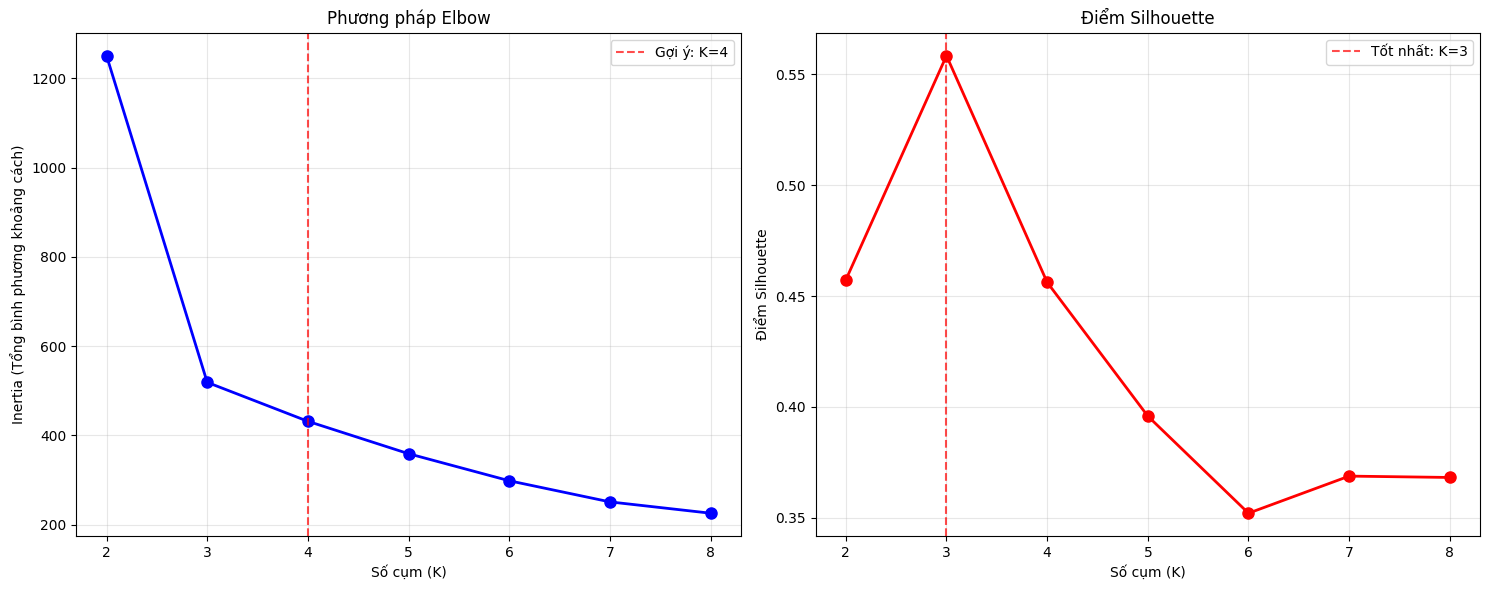


=== GỢI Ý SỐ CỤM TỐI ƯU ===
Dựa trên điểm Silhouette: K = 3
Điểm Silhouette cao nhất: 0.558
Dựa trên phương pháp Elbow: K = 4


3

In [2]:
class TimSoCumToiUu:
    """
    Lớp tìm số cụm tối ưu cho K-means
    """
    
    def __init__(self, max_clusters=10):
        # max_clusters: số cụm lớn nhất sẽ thử (từ 2 đến max_clusters)
        self.max_clusters = max_clusters
        # inertias: lưu giá trị inertia (tổng bình phương khoảng cách) cho mỗi K
        self.inertias = []
        # silhouette_scores: lưu điểm silhouette cho mỗi K
        self.silhouette_scores = []
        # k_range: dãy các giá trị K cần thử, bắt đầu từ 2
        self.k_range = range(2, max_clusters + 1)
    
    def tim_so_cum_elbow(self, data):
        """
        Tìm số cụm tối ưu bằng phương pháp Elbow:
        - Tính inertia và silhouette cho mỗi K
        """
        print("Đang tìm số cụm tối ưu bằng phương pháp Elbow...")
        
        # Reset danh sách trước khi tính toán
        self.inertias = []
        self.silhouette_scores = []
        
        # Lặp qua từng giá trị k trong k_range
        for k in self.k_range:
            # Khởi tạo và huấn luyện mô hình KMeans với k cụm
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(data)
            
            # Lưu inertia: tổng bình phương khoảng cách từ điểm đến tâm cụm
            self.inertias.append(kmeans.inertia_)
            # Tính silhouette score: đánh giá chất lượng phân cụm
            silhouette = silhouette_score(data, kmeans.labels_)
            self.silhouette_scores.append(silhouette)
            
            # In kết quả từng bước
            print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette:.3f}")
    
    def ve_bieu_do_elbow(self):
        """
        Vẽ biểu đồ Elbow (Inertia vs K) và điểm Silhouette (Silhouette vs K),
        đồng thời đánh dấu gợi ý K tối ưu trên các đồ thị.
        """
        # Tạo figure với 2 cột: một cho Elbow, một cho Silhouette
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # --- Biểu đồ Elbow ---
        axes[0].plot(self.k_range, self.inertias, 'bo-', linewidth=2, markersize=8)
        axes[0].set_title('Phương pháp Elbow')
        axes[0].set_xlabel('Số cụm (K)')
        axes[0].set_ylabel('Inertia (Tổng bình phương khoảng cách)')
        axes[0].grid(True, alpha=0.3)
        
        # Nếu có đủ dữ liệu, tìm "khuỷu tay" bằng second derivative
        if len(self.inertias) >= 3:
            # decreases[i] = inertia[i] - inertia[i+1]
            decreases = [
                self.inertias[i] - self.inertias[i+1]
                for i in range(len(self.inertias)-1)
            ]
            if len(decreases) >= 2:
                # second_derivatives[i] = decreases[i] - decreases[i+1]
                second_derivatives = [
                    decreases[i] - decreases[i+1]
                    for i in range(len(decreases)-1)
                ]
                if second_derivatives:
                    # Vị trí K có biến đổi lớn nhất trong second derivative
                    elbow_idx = np.argmax(second_derivatives) + 2  
                    elbow_k = self.k_range[elbow_idx]
                    # Vẽ đường dọc gợi ý K
                    axes[0].axvline(
                        elbow_k, color='red', linestyle='--', alpha=0.7,
                        label=f'Gợi ý: K={elbow_k}'
                    )
                    axes[0].legend()
        
        # --- Biểu đồ Silhouette ---
        axes[1].plot(self.k_range, self.silhouette_scores, 'ro-', linewidth=2, markersize=8)
        axes[1].set_title('Điểm Silhouette')
        axes[1].set_xlabel('Số cụm (K)')
        axes[1].set_ylabel('Điểm Silhouette')
        axes[1].grid(True, alpha=0.3)
        
        # Đánh dấu K có silhouette cao nhất
        best_idx = np.argmax(self.silhouette_scores)
        best_k = self.k_range[best_idx]
        axes[1].axvline(
            best_k, color='red', linestyle='--', alpha=0.7,
            label=f'Tốt nhất: K={best_k}'
        )
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Trả về K gợi ý dựa trên silhouette
        return best_k
    
    def goi_y_so_cum(self):
        """
        In ra gợi ý số cụm tối ưu:
        - Dựa trên silhouette
        - Dựa trên phương pháp Elbow (second derivative)
        """
        # Gợi ý dựa trên silhouette score
        best_silhouette_idx = np.argmax(self.silhouette_scores)
        best_k_silhouette = self.k_range[best_silhouette_idx]
        
        print(f"\n=== GỢI Ý SỐ CỤM TỐI ƯU ===")
        print(f"Dựa trên điểm Silhouette: K = {best_k_silhouette}")
        print(f"Điểm Silhouette cao nhất: {self.silhouette_scores[best_silhouette_idx]:.3f}")
        
        # Gợi ý dựa trên Elbow: second difference của inertia
        if len(self.inertias) >= 3:
            differences = np.diff(self.inertias)       # first derivative
            second_differences = np.diff(differences)  # second derivative
            if len(second_differences) > 0:
                elbow_idx = np.argmax(second_differences) + 2
                elbow_k = self.k_range[elbow_idx]
                print(f"Dựa trên phương pháp Elbow: K = {elbow_k}")
        
        # Trả về K gợi ý theo silhouette
        return best_k_silhouette

# Ví dụ sử dụng với dữ liệu mẫu `data_mau`:
tim_cum = TimSoCumToiUu(max_clusters=8)   # Khởi tạo thử K từ 2 đến 8
tim_cum.tim_so_cum_elbow(data_mau)        # Tính inertia và silhouette
so_cum_toi_uu = tim_cum.ve_bieu_do_elbow()# Vẽ đồ thị và lấy gợi ý
tim_cum.goi_y_so_cum()                    # In gợi ý chi tiết



=== MINH HỌA PHÂN CỤM PHÂN CẤP ===
Đã hoàn thành phân cụm phân cấp với 3 cụm
Phương pháp liên kết: ward
Hiển thị dendrogram cho 30 điểm đầu tiên


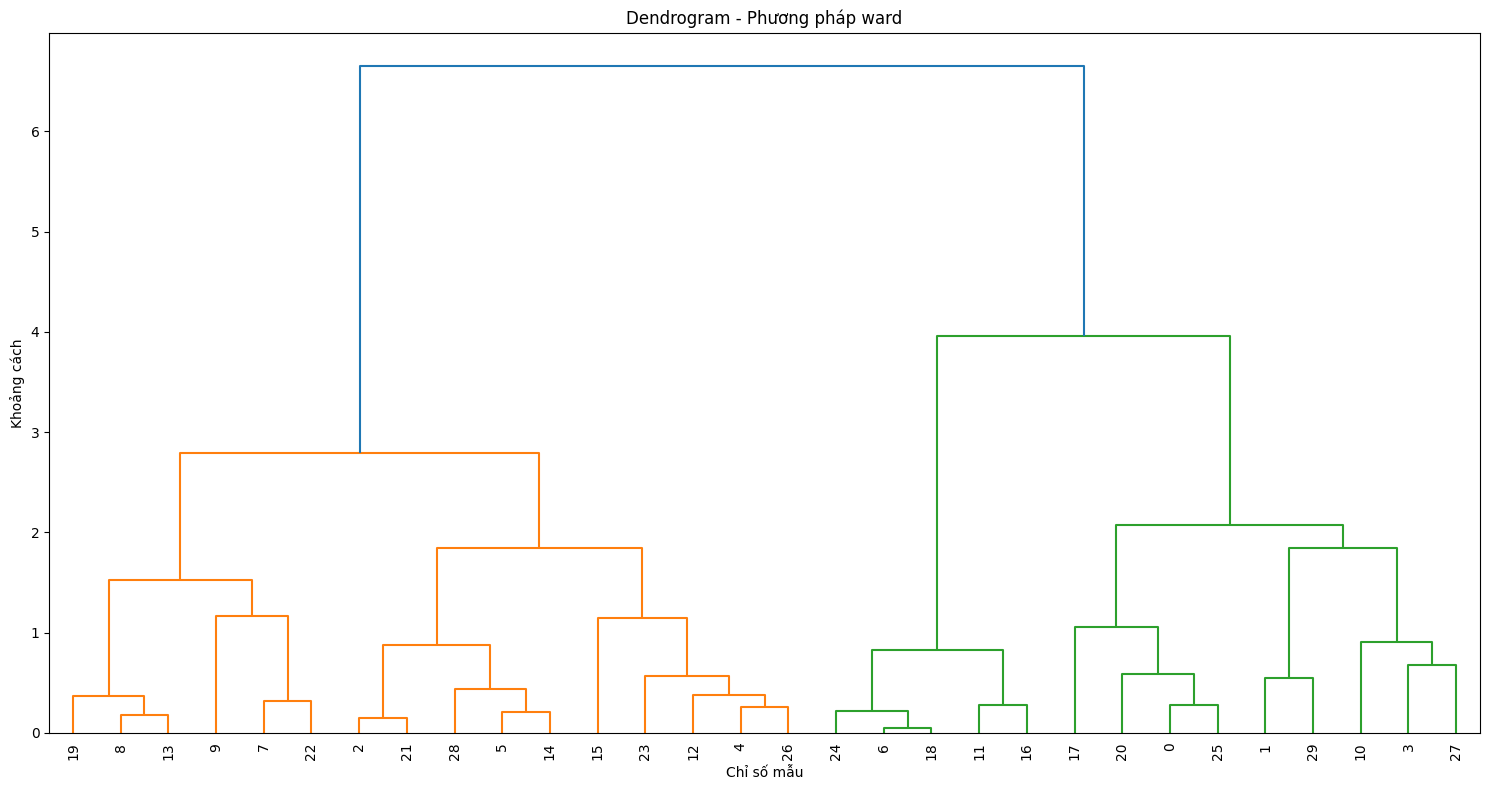

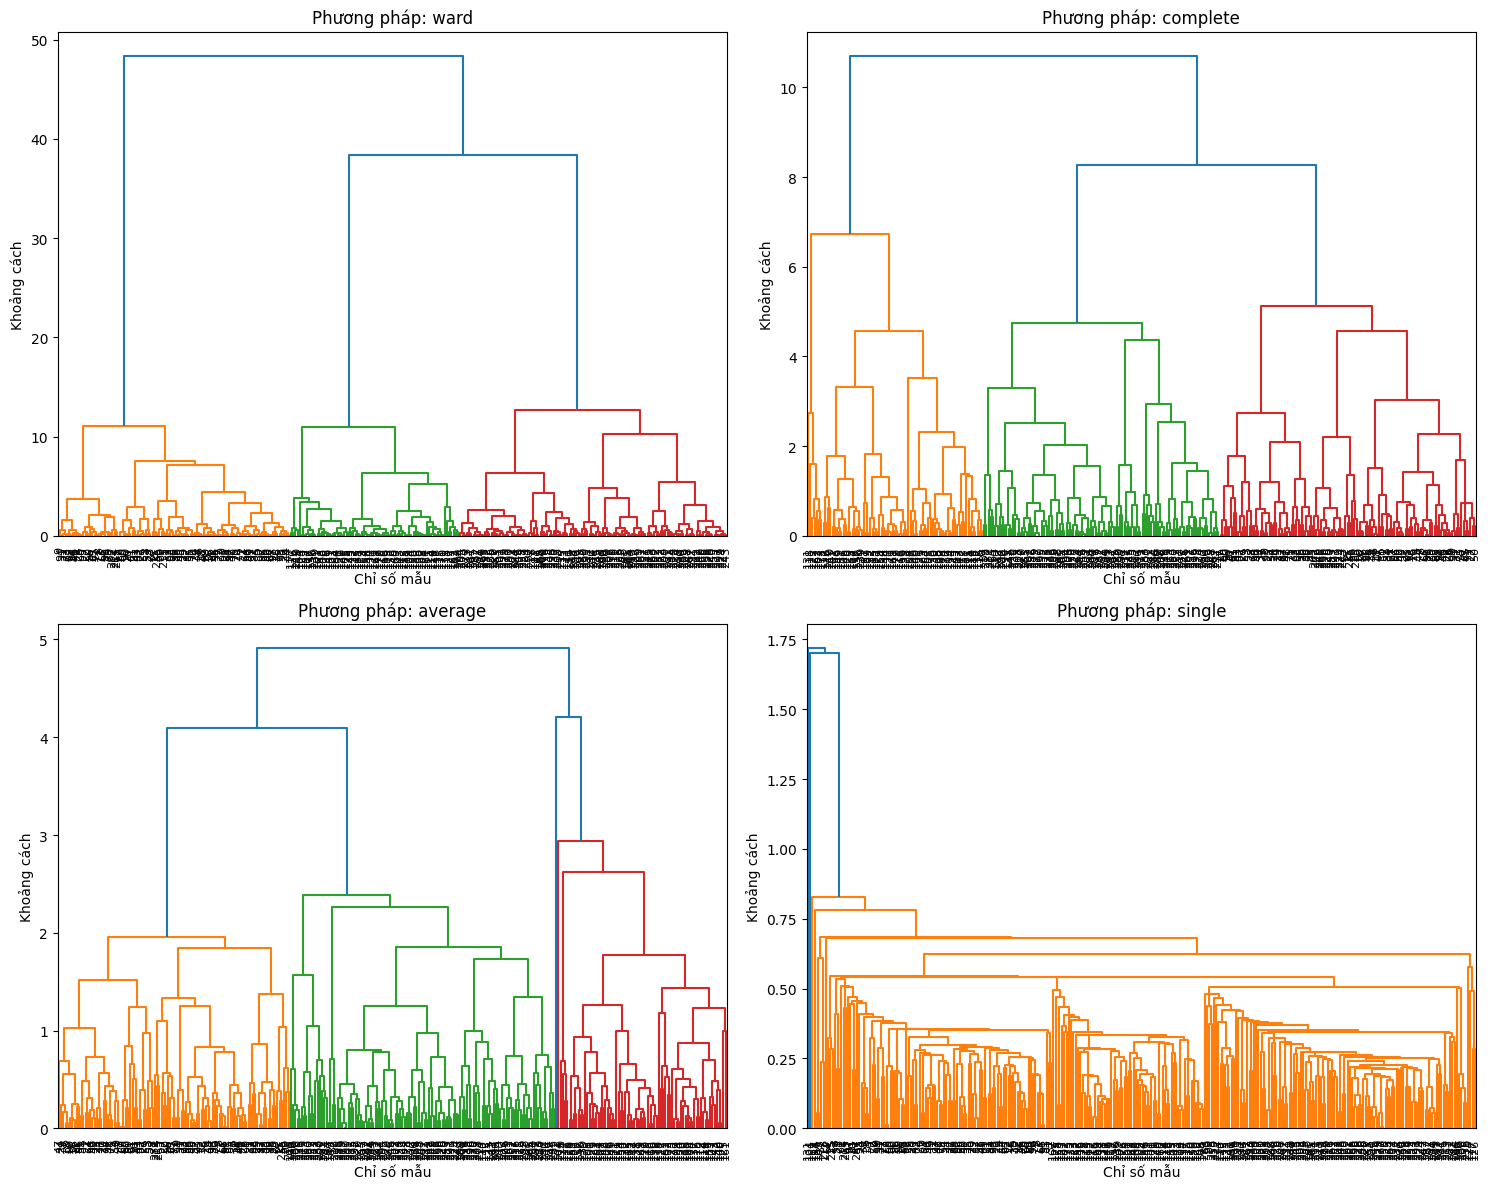


So sánh chất lượng phân cụm (điểm Silhouette):
    ward: 0.553
complete: 0.505
 average: 0.424
  single: 0.254

So sánh điểm Silhouette:
K-means: 0.558
Phân cụm phân cấp: 0.553


In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

class PhanCumPhanCap:
    """
    Lớp thực hiện phân cụm phân cấp
    """
    
    def __init__(self, linkage_method='ward', distance_threshold=None, n_clusters=None):
        self.linkage_method = linkage_method
        self.distance_threshold = distance_threshold
        self.n_clusters = n_clusters
        self.model = None
        self.labels = None
        self.linkage_matrix = None
    
    def huan_luyen(self, data):
        """
        Huấn luyện mô hình phân cụm phân cấp
        """
        # Tính toán ma trận linkage
        self.linkage_matrix = linkage(data, method=self.linkage_method)
        
        # Tạo mô hình phân cụm
        if self.n_clusters is not None:
            self.model = AgglomerativeClustering(
                n_clusters=self.n_clusters,
                linkage=self.linkage_method
            )
        else:
            self.model = AgglomerativeClustering(
                distance_threshold=self.distance_threshold,
                n_clusters=None,
                linkage=self.linkage_method
            )
        
        # Thực hiện phân cụm
        self.labels = self.model.fit_predict(data)
        
        so_cum_thuc_te = len(np.unique(self.labels))
        print(f"Đã hoàn thành phân cụm phân cấp với {so_cum_thuc_te} cụm")
        print(f"Phương pháp liên kết: {self.linkage_method}")
        
        return self
    
    def ve_dendrogram(self, data, max_display=30):
        """
        Vẽ biểu đồ dendrogram
        """
        plt.figure(figsize=(15, 8))
        
        # Nếu có quá nhiều điểm, chỉ hiển thị một phần
        if len(data) > max_display:
            print(f"Hiển thị dendrogram cho {max_display} điểm đầu tiên")
            linkage_subset = linkage(data[:max_display], method=self.linkage_method)
            dendrogram(linkage_subset, leaf_rotation=90, leaf_font_size=10)
        else:
            dendrogram(self.linkage_matrix, leaf_rotation=90, leaf_font_size=10)
        
        plt.title(f'Dendrogram - Phương pháp {self.linkage_method}')
        plt.xlabel('Chỉ số mẫu')
        plt.ylabel('Khoảng cách')
        
        # Thêm đường ngang cho ngưỡng cắt
        if self.distance_threshold is not None:
            plt.axhline(y=self.distance_threshold, color='red', linestyle='--', 
                       label=f'Ngưỡng cắt: {self.distance_threshold:.2f}')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def so_sanh_phuong_phap(self, data):
        """
        So sánh các phương pháp liên kết khác nhau
        """
        methods = ['ward', 'complete', 'average', 'single']
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        for i, method in enumerate(methods):
            # Tính linkage cho từng phương pháp
            linkage_matrix = linkage(data, method=method)
            
            # Vẽ dendrogram
            dendrogram(linkage_matrix, ax=axes[i], leaf_rotation=90, leaf_font_size=8)
            axes[i].set_title(f'Phương pháp: {method}')
            axes[i].set_xlabel('Chỉ số mẫu')
            axes[i].set_ylabel('Khoảng cách')
        
        plt.tight_layout()
        plt.show()
        
        # So sánh chất lượng phân cụm
        print("\nSo sánh chất lượng phân cụm (điểm Silhouette):")
        for method in methods:
            model = AgglomerativeClustering(n_clusters=3, linkage=method)
            labels = model.fit_predict(data)
            silhouette = silhouette_score(data, labels)
            print(f"{method:>8}: {silhouette:.3f}")

# Minh họa phân cụm phân cấp
print("\n=== MINH HỌA PHÂN CỤM PHÂN CẤP ===")

# Sử dụng cùng dữ liệu mẫu
phan_cap = PhanCumPhanCap(n_clusters=3, linkage_method='ward')
phan_cap.huan_luyen(data_mau)

# Vẽ dendrogram
phan_cap.ve_dendrogram(data_mau)

# So sánh các phương pháp
phan_cap.so_sanh_phuong_phap(data_mau)

# So sánh kết quả với K-means
silhouette_hierarchical = silhouette_score(data_mau, phan_cap.labels)
print(f"\nSo sánh điểm Silhouette:")
print(f"K-means: {silhouette:.3f}")
print(f"Phân cụm phân cấp: {silhouette_hierarchical:.3f}")


=== MINH HỌA GIẢM CHIỀU DỮ LIỆU BẰNG PCA ===
Dữ liệu gốc có 5 chiều, 300 mẫu
Đã giảm từ 5 xuống 2 chiều
Tỷ lệ phương sai được giữ lại:
  Thành phần chính 1: 0.537 (53.7%)
  Thành phần chính 2: 0.285 (28.5%)
Tổng cộng: 0.822 (82.2%)
Để giữ lại 90% phương sai, cần 4 thành phần chính


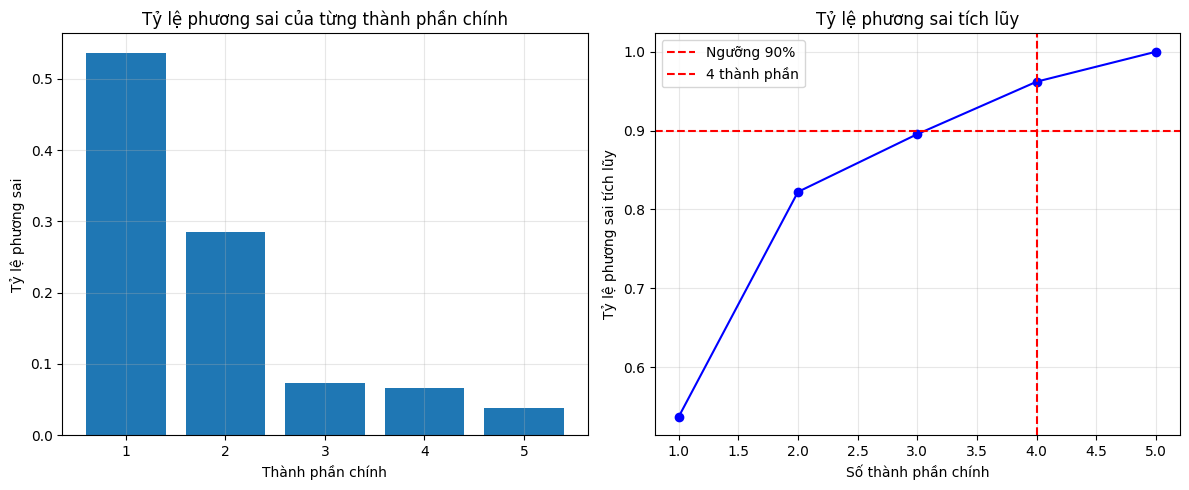

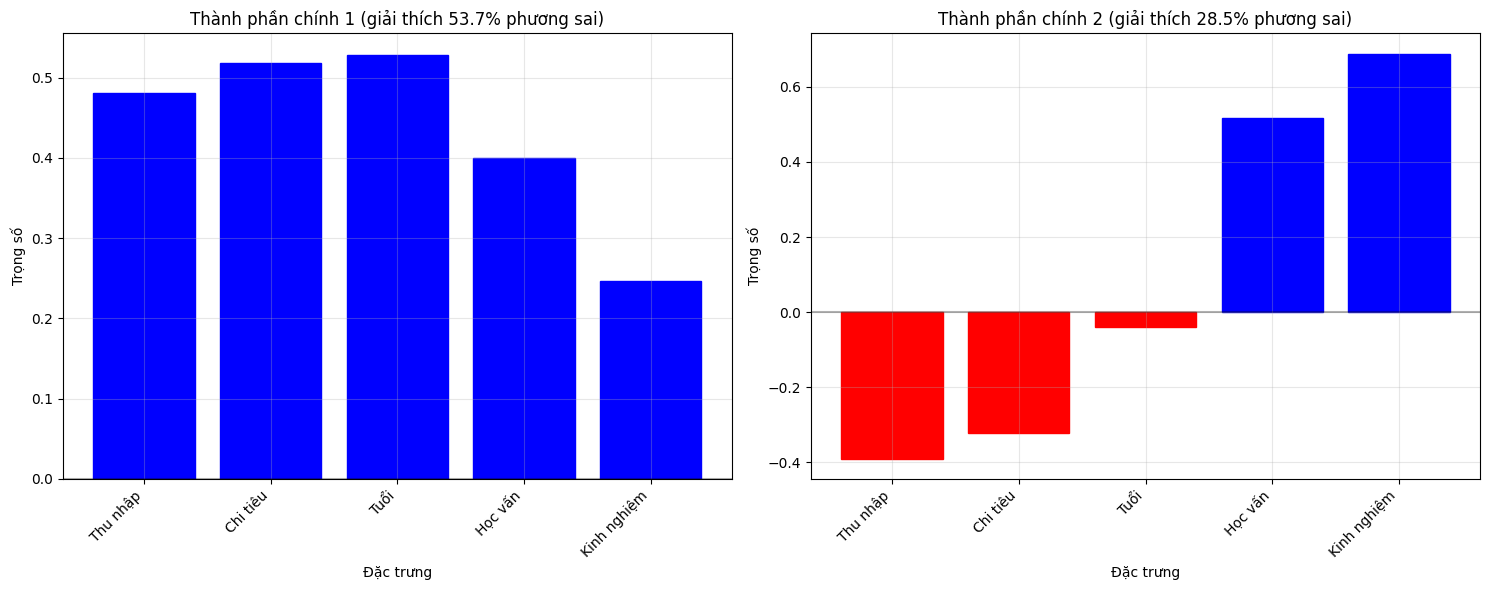


Phân tích chi tiết các thành phần chính:

Thành phần chính 1:
  Giải thích 53.7% phương sai
  Top 3 đặc trưng quan trọng nhất:
    1. Tuổi: 0.529
    2. Chi tiêu: 0.518
    3. Thu nhập: 0.481

Thành phần chính 2:
  Giải thích 28.5% phương sai
  Top 3 đặc trưng quan trọng nhất:
    1. Kinh nghiệm: 0.689
    2. Học vấn: 0.517
    3. Thu nhập: -0.391


In [4]:
class GiamChieuPCA:
    """
    Lớp thực hiện giảm chiều dữ liệu bằng PCA
    """
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.pca = None
        self.explained_variance_ratio = None
        self.components = None
    
    def huan_luyen(self, data):
        """
        Huấn luyện mô hình PCA
        """
        self.pca = PCA(n_components=self.n_components)
        transformed_data = self.pca.fit_transform(data)
        
        self.explained_variance_ratio = self.pca.explained_variance_ratio_
        self.components = self.pca.components_
        
        print(f"Đã giảm từ {data.shape[1]} xuống {self.n_components} chiều")
        print(f"Tỷ lệ phương sai được giữ lại:")
        for i, ratio in enumerate(self.explained_variance_ratio):
            print(f"  Thành phần chính {i+1}: {ratio:.3f} ({ratio*100:.1f}%)")
        print(f"Tổng cộng: {self.explained_variance_ratio.sum():.3f} ({self.explained_variance_ratio.sum()*100:.1f}%)")
        
        return transformed_data
    
    def chuyen_doi(self, data):
        """
        Chuyển đổi dữ liệu mới
        """
        if self.pca is None:
            raise ValueError("Chưa huấn luyện mô hình PCA")
        return self.pca.transform(data)
    
    def tim_so_thanh_phan_toi_uu(self, data, variance_threshold=0.95):
        """
        Tìm số thành phần chính cần thiết để giữ lại một tỷ lệ phương sai nhất định
        """
        # Thử với tất cả các thành phần có thể
        pca_full = PCA()
        pca_full.fit(data)
        
        # Tính tỷ lệ phương sai tích lũy
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
        
        # Tìm số thành phần cần thiết
        n_components_needed = np.argmax(cumulative_variance >= variance_threshold) + 1
        
        print(f"Để giữ lại {variance_threshold*100:.0f}% phương sai, cần {n_components_needed} thành phần chính")
        
        # Vẽ biểu đồ
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
                pca_full.explained_variance_ratio_)
        plt.title('Tỷ lệ phương sai của từng thành phần chính')
        plt.xlabel('Thành phần chính')
        plt.ylabel('Tỷ lệ phương sai')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
        plt.axhline(y=variance_threshold, color='red', linestyle='--', 
                   label=f'Ngưỡng {variance_threshold*100:.0f}%')
        plt.axvline(x=n_components_needed, color='red', linestyle='--', 
                   label=f'{n_components_needed} thành phần')
        plt.title('Tỷ lệ phương sai tích lũy')
        plt.xlabel('Số thành phần chính')
        plt.ylabel('Tỷ lệ phương sai tích lũy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return n_components_needed
    
    def phan_tich_thanh_phan(self, data, feature_names=None):
        """
        Phân tích các thành phần chính
        """
        if self.components is None:
            raise ValueError("Chưa huấn luyện mô hình PCA")
        
        if feature_names is None:
            feature_names = [f'Đặc trưng {i+1}' for i in range(data.shape[1])]
        
        # Vẽ biểu đồ loading
        fig, axes = plt.subplots(1, min(2, self.n_components), figsize=(15, 6))
        if self.n_components == 1:
            axes = [axes]
        
        for i in range(min(2, self.n_components)):
            # Vẽ loading plot
            loadings = self.components[i]
            bars = axes[i].bar(range(len(feature_names)), loadings)
            
            # Tô màu dương/âm
            for j, bar in enumerate(bars):
                if loadings[j] >= 0:
                    bar.set_color('blue')
                else:
                    bar.set_color('red')
            
            axes[i].set_title(f'Thành phần chính {i+1} (giải thích {self.explained_variance_ratio[i]*100:.1f}% phương sai)')
            axes[i].set_xlabel('Đặc trưng')
            axes[i].set_ylabel('Trọng số')
            axes[i].set_xticks(range(len(feature_names)))
            axes[i].set_xticklabels(feature_names, rotation=45, ha='right')
            axes[i].grid(True, alpha=0.3)
            axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # In thông tin chi tiết về các thành phần
        print("\nPhân tích chi tiết các thành phần chính:")
        for i in range(self.n_components):
            print(f"\nThành phần chính {i+1}:")
            print(f"  Giải thích {self.explained_variance_ratio[i]*100:.1f}% phương sai")
            
            # Tìm các đặc trưng có ảnh hưởng lớn nhất
            loadings = np.abs(self.components[i])
            important_features = np.argsort(loadings)[::-1][:3]
            
            print(f"  Top 3 đặc trưng quan trọng nhất:")
            for j, idx in enumerate(important_features):
                print(f"    {j+1}. {feature_names[idx]}: {self.components[i][idx]:.3f}")

# Tạo dữ liệu nhiều chiều để minh họa PCA
def tao_du_lieu_nhieu_chieu():
    """
    Tạo dữ liệu nhiều chiều có tương quan
    """
    np.random.seed(42)
    n_samples = 300
    
    # Tạo ma trận tương quan
    corr_matrix = np.array([
        [1.0, 0.8, 0.6, 0.3, 0.1],
        [0.8, 1.0, 0.7, 0.4, 0.2],
        [0.6, 0.7, 1.0, 0.5, 0.3],
        [0.3, 0.4, 0.5, 1.0, 0.6],
        [0.1, 0.2, 0.3, 0.6, 1.0]
    ])
    
    # Tạo dữ liệu từ phân phối chuẩn đa biến
    data = np.random.multivariate_normal(
        mean=np.zeros(5),
        cov=corr_matrix,
        size=n_samples
    )
    
    feature_names = ['Thu nhập', 'Chi tiêu', 'Tuổi', 'Học vấn', 'Kinh nghiệm']
    
    return data, feature_names

# Minh họa PCA
print("\n=== MINH HỌA GIẢM CHIỀU DỮ LIỆU BẰNG PCA ===")

data_nhieu_chieu, ten_dac_trung = tao_du_lieu_nhieu_chieu()
print(f"Dữ liệu gốc có {data_nhieu_chieu.shape[1]} chiều, {data_nhieu_chieu.shape[0]} mẫu")

# Chuẩn hóa dữ liệu trước khi áp dụng PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_nhieu_chieu)

# Áp dụng PCA
pca_model = GiamChieuPCA(n_components=2)
data_pca = pca_model.huan_luyen(data_scaled)

# Tìm số thành phần tối ưu
so_thanh_phan_toi_uu = pca_model.tim_so_thanh_phan_toi_uu(data_scaled, variance_threshold=0.9)

# Phân tích các thành phần chính
pca_model.phan_tich_thanh_phan(data_scaled, ten_dac_trung)


=== MINH HỌA GIẢM CHIỀU DỮ LIỆU BẰNG PCA ===
Dữ liệu gốc có 5 chiều, 300 mẫu
Đã giảm từ 5 xuống 2 chiều
Tỷ lệ phương sai được giữ lại:
  Thành phần chính 1: 0.537 (53.7%)
  Thành phần chính 2: 0.285 (28.5%)
Tổng cộng: 0.822 (82.2%)
Để giữ lại 90% phương sai, cần 4 thành phần chính


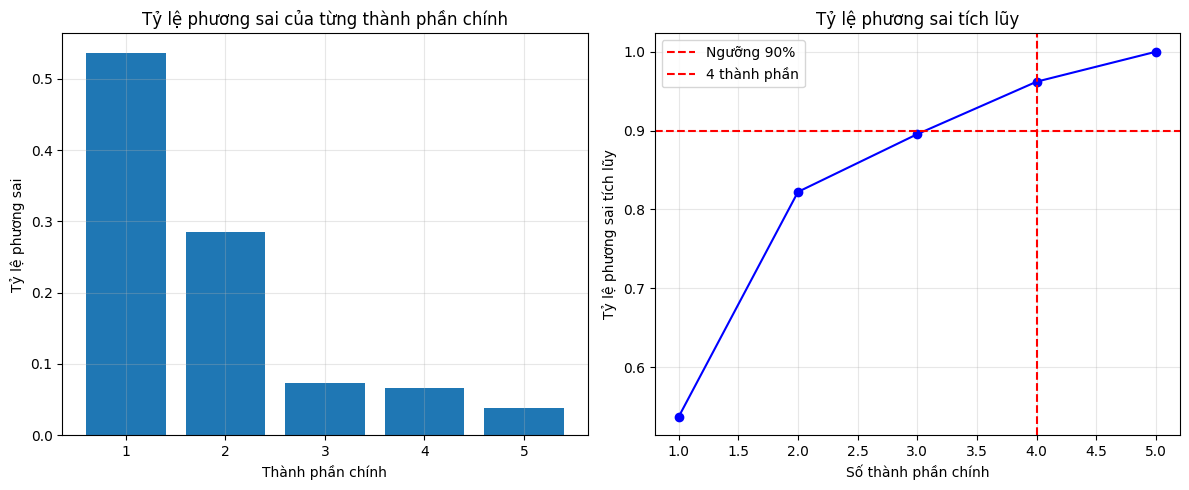

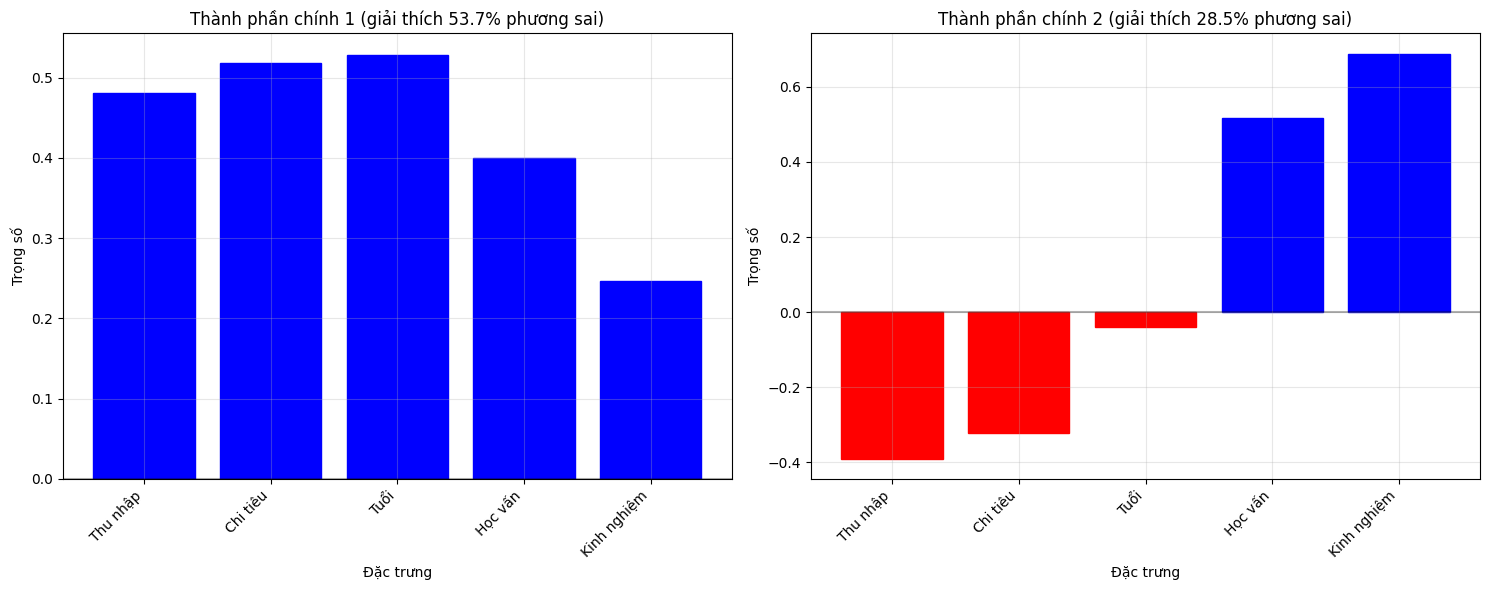


Phân tích chi tiết các thành phần chính:

Thành phần chính 1:
  Giải thích 53.7% phương sai
  Top 3 đặc trưng quan trọng nhất:
    1. Tuổi: 0.529
    2. Chi tiêu: 0.518
    3. Thu nhập: 0.481

Thành phần chính 2:
  Giải thích 28.5% phương sai
  Top 3 đặc trưng quan trọng nhất:
    1. Kinh nghiệm: 0.689
    2. Học vấn: 0.517
    3. Thu nhập: -0.391


In [5]:
class GiamChieuPCA:
    """
    Lớp thực hiện giảm chiều dữ liệu bằng PCA
    """
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.pca = None
        self.explained_variance_ratio = None
        self.components = None
    
    def huan_luyen(self, data):
        """
        Huấn luyện mô hình PCA
        """
        self.pca = PCA(n_components=self.n_components)
        transformed_data = self.pca.fit_transform(data)
        
        self.explained_variance_ratio = self.pca.explained_variance_ratio_
        self.components = self.pca.components_
        
        print(f"Đã giảm từ {data.shape[1]} xuống {self.n_components} chiều")
        print(f"Tỷ lệ phương sai được giữ lại:")
        for i, ratio in enumerate(self.explained_variance_ratio):
            print(f"  Thành phần chính {i+1}: {ratio:.3f} ({ratio*100:.1f}%)")
        print(f"Tổng cộng: {self.explained_variance_ratio.sum():.3f} ({self.explained_variance_ratio.sum()*100:.1f}%)")
        
        return transformed_data
    
    def chuyen_doi(self, data):
        """
        Chuyển đổi dữ liệu mới
        """
        if self.pca is None:
            raise ValueError("Chưa huấn luyện mô hình PCA")
        return self.pca.transform(data)
    
    def tim_so_thanh_phan_toi_uu(self, data, variance_threshold=0.95):
        """
        Tìm số thành phần chính cần thiết để giữ lại một tỷ lệ phương sai nhất định
        """
        # Thử với tất cả các thành phần có thể
        pca_full = PCA()
        pca_full.fit(data)
        
        # Tính tỷ lệ phương sai tích lũy
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
        
        # Tìm số thành phần cần thiết
        n_components_needed = np.argmax(cumulative_variance >= variance_threshold) + 1
        
        print(f"Để giữ lại {variance_threshold*100:.0f}% phương sai, cần {n_components_needed} thành phần chính")
        
        # Vẽ biểu đồ
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
                pca_full.explained_variance_ratio_)
        plt.title('Tỷ lệ phương sai của từng thành phần chính')
        plt.xlabel('Thành phần chính')
        plt.ylabel('Tỷ lệ phương sai')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
        plt.axhline(y=variance_threshold, color='red', linestyle='--', 
                   label=f'Ngưỡng {variance_threshold*100:.0f}%')
        plt.axvline(x=n_components_needed, color='red', linestyle='--', 
                   label=f'{n_components_needed} thành phần')
        plt.title('Tỷ lệ phương sai tích lũy')
        plt.xlabel('Số thành phần chính')
        plt.ylabel('Tỷ lệ phương sai tích lũy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return n_components_needed
    
    def phan_tich_thanh_phan(self, data, feature_names=None):
        """
        Phân tích các thành phần chính
        """
        if self.components is None:
            raise ValueError("Chưa huấn luyện mô hình PCA")
        
        if feature_names is None:
            feature_names = [f'Đặc trưng {i+1}' for i in range(data.shape[1])]
        
        # Vẽ biểu đồ loading
        fig, axes = plt.subplots(1, min(2, self.n_components), figsize=(15, 6))
        if self.n_components == 1:
            axes = [axes]
        
        for i in range(min(2, self.n_components)):
            # Vẽ loading plot
            loadings = self.components[i]
            bars = axes[i].bar(range(len(feature_names)), loadings)
            
            # Tô màu dương/âm
            for j, bar in enumerate(bars):
                if loadings[j] >= 0:
                    bar.set_color('blue')
                else:
                    bar.set_color('red')
            
            axes[i].set_title(f'Thành phần chính {i+1} (giải thích {self.explained_variance_ratio[i]*100:.1f}% phương sai)')
            axes[i].set_xlabel('Đặc trưng')
            axes[i].set_ylabel('Trọng số')
            axes[i].set_xticks(range(len(feature_names)))
            axes[i].set_xticklabels(feature_names, rotation=45, ha='right')
            axes[i].grid(True, alpha=0.3)
            axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # In thông tin chi tiết về các thành phần
        print("\nPhân tích chi tiết các thành phần chính:")
        for i in range(self.n_components):
            print(f"\nThành phần chính {i+1}:")
            print(f"  Giải thích {self.explained_variance_ratio[i]*100:.1f}% phương sai")
            
            # Tìm các đặc trưng có ảnh hưởng lớn nhất
            loadings = np.abs(self.components[i])
            important_features = np.argsort(loadings)[::-1][:3]
            
            print(f"  Top 3 đặc trưng quan trọng nhất:")
            for j, idx in enumerate(important_features):
                print(f"    {j+1}. {feature_names[idx]}: {self.components[i][idx]:.3f}")

# Tạo dữ liệu nhiều chiều để minh họa PCA
def tao_du_lieu_nhieu_chieu():
    """
    Tạo dữ liệu nhiều chiều có tương quan
    """
    np.random.seed(42)
    n_samples = 300
    
    # Tạo ma trận tương quan
    corr_matrix = np.array([
        [1.0, 0.8, 0.6, 0.3, 0.1],
        [0.8, 1.0, 0.7, 0.4, 0.2],
        [0.6, 0.7, 1.0, 0.5, 0.3],
        [0.3, 0.4, 0.5, 1.0, 0.6],
        [0.1, 0.2, 0.3, 0.6, 1.0]
    ])
    
    # Tạo dữ liệu từ phân phối chuẩn đa biến
    data = np.random.multivariate_normal(
        mean=np.zeros(5),
        cov=corr_matrix,
        size=n_samples
    )
    
    feature_names = ['Thu nhập', 'Chi tiêu', 'Tuổi', 'Học vấn', 'Kinh nghiệm']
    
    return data, feature_names

# Minh họa PCA
print("\n=== MINH HỌA GIẢM CHIỀU DỮ LIỆU BẰNG PCA ===")

data_nhieu_chieu, ten_dac_trung = tao_du_lieu_nhieu_chieu()
print(f"Dữ liệu gốc có {data_nhieu_chieu.shape[1]} chiều, {data_nhieu_chieu.shape[0]} mẫu")

# Chuẩn hóa dữ liệu trước khi áp dụng PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_nhieu_chieu)

# Áp dụng PCA
pca_model = GiamChieuPCA(n_components=2)
data_pca = pca_model.huan_luyen(data_scaled)

# Tìm số thành phần tối ưu
so_thanh_phan_toi_uu = pca_model.tim_so_thanh_phan_toi_uu(data_scaled, variance_threshold=0.9)

# Phân tích các thành phần chính
pca_model.phan_tich_thanh_phan(data_scaled, ten_dac_trung)

BÀI THỰC HÀNH: PHÂN ĐOẠN KHÁCH HÀNG THƯƠNG MẠI ĐIỆN TỬ
Đã tạo dữ liệu khách hàng thành công!
Đã tải dữ liệu: (2000, 9)
Các cột: ['khach_hang_id', 'recency', 'frequency', 'monetary', 'tuoi', 'thu_nhap_uoc_tinh', 'so_trang_xem', 'thoi_gian_tren_site', 'phan_doan_thuc']
Đã chuẩn hóa 7 đặc trưng
=== THỐNG KÊ MÔ TẢ ===
           recency    frequency      monetary         tuoi
count  2000.000000  2000.000000  2.000000e+03  2000.000000
mean     81.307000    12.519000  3.357451e+06    33.773000
std      78.429148    11.545574  3.971931e+06    10.111755
min       0.000000     1.000000  1.033700e+05    18.000000
25%      26.750000     4.000000  8.256245e+05    26.000000
50%      51.000000     9.000000  1.969472e+06    33.000000
75%     103.000000    18.000000  4.370795e+06    41.000000
max     336.000000    58.000000  1.999576e+07    70.000000


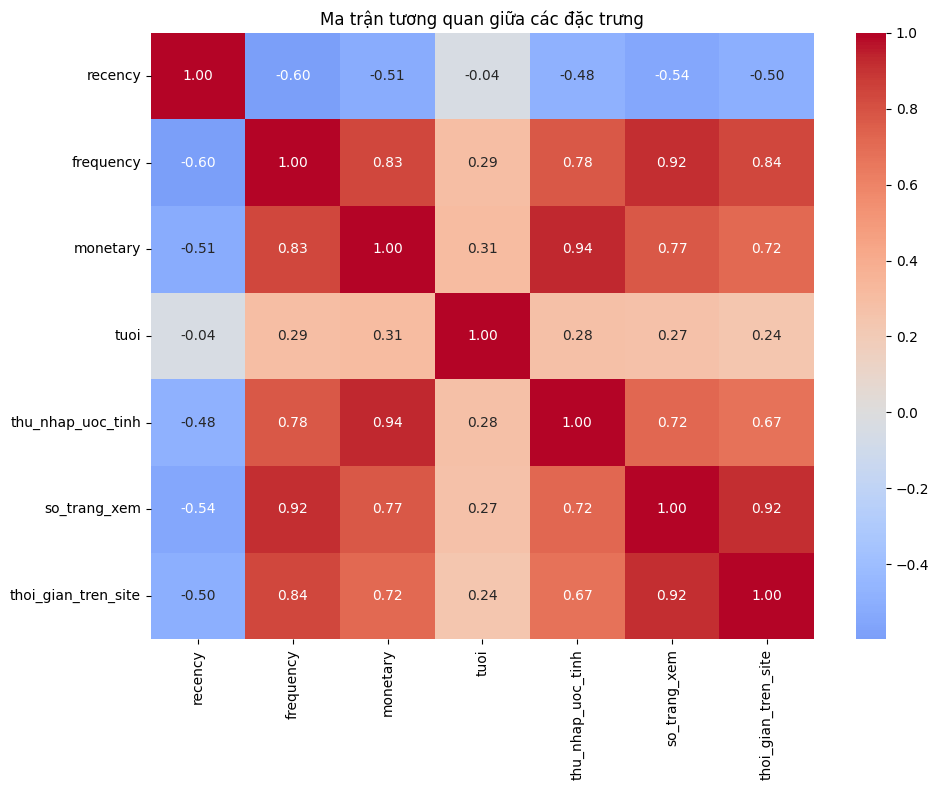

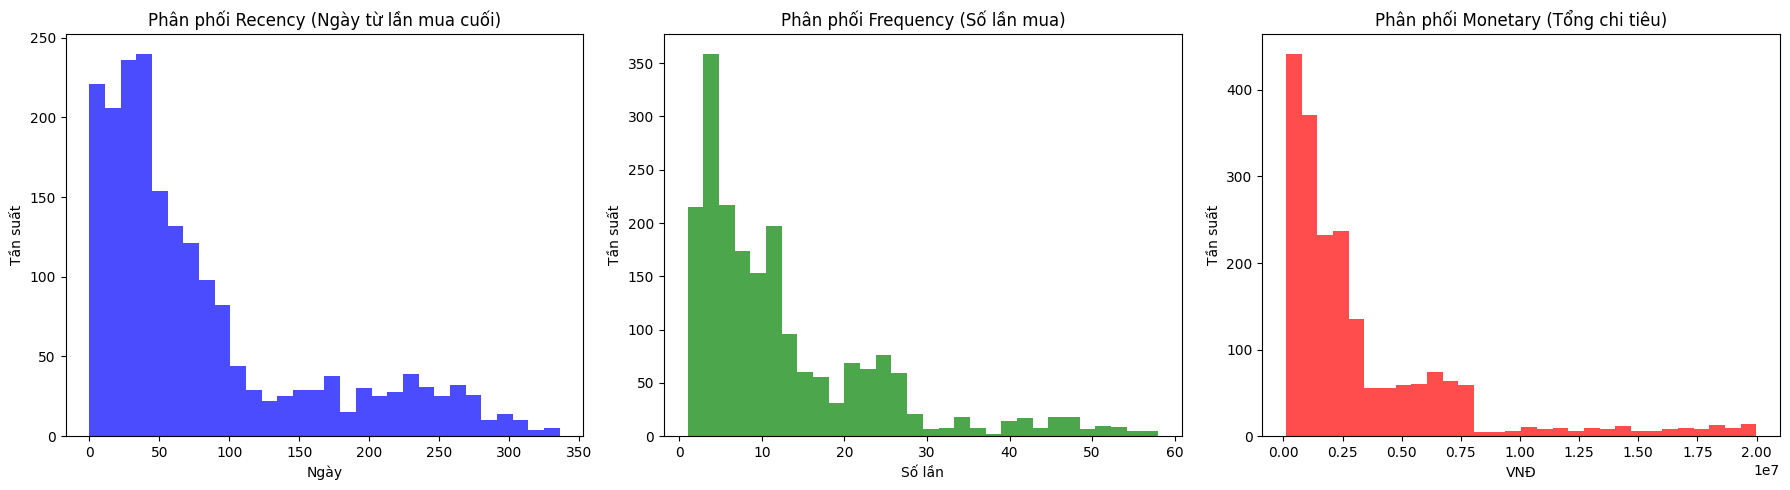


=== TÌM SỐ CỤM TỐI ƯU ===


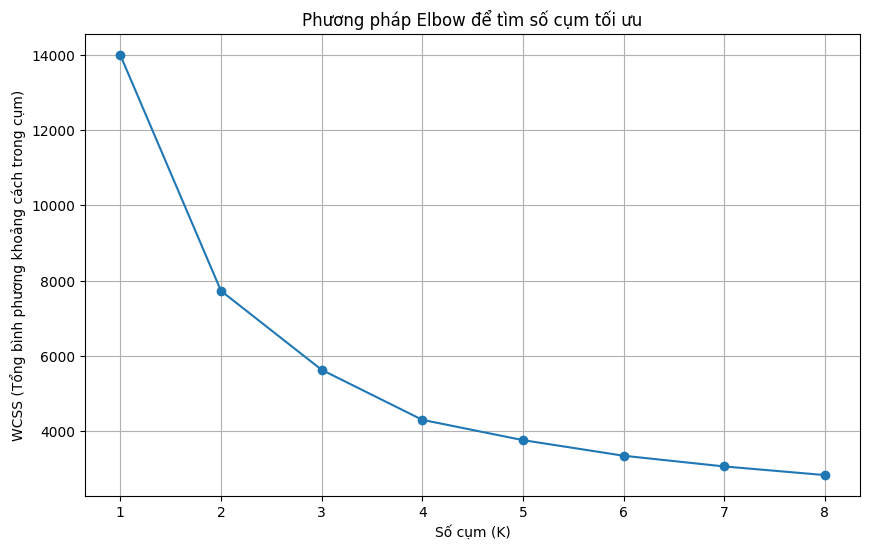

Gợi ý số cụm tối ưu: 4 (dựa trên phương pháp Elbow)

=== THỰC HIỆN PHÂN CỤM VỚI 4 CỤM ===
Điểm Silhouette: 0.342

=== PHÂN TÍCH CHI TIẾT CÁC CỤM ===

CỤM 1:
  Số lượng khách hàng: 920 (46.0%)
  RFM trung bình:
    Recency: 60 ngày
    Frequency: 8 lần
    Monetary: 1,804,342 VNĐ
  Thông tin khác:
    Tuổi trung bình: 30
    Thu nhập ước tính: 355,298 VNĐ
    Số trang xem: 82
    Thời gian trên site: 166.0 phút

CỤM 2:
  Số lượng khách hàng: 463 (23.2%)
  RFM trung bình:
    Recency: 23 ngày
    Frequency: 21 lần
    Monetary: 5,491,915 VNĐ
  Thông tin khác:
    Tuổi trung bình: 37
    Thu nhập ước tính: 1,082,334 VNĐ
    Số trang xem: 210
    Thời gian trên site: 418.9 phút

CỤM 3:
  Số lượng khách hàng: 455 (22.8%)
  RFM trung bình:
    Recency: 209 ngày
    Frequency: 3 lần
    Monetary: 560,524 VNĐ
  Thông tin khác:
    Tuổi trung bình: 35
    Thu nhập ước tính: 111,328 VNĐ
    Số trang xem: 32
    Thời gian trên site: 63.3 phút

CỤM 4:
  Số lượng khách hàng: 162 (8.1%)
  RFM trung 

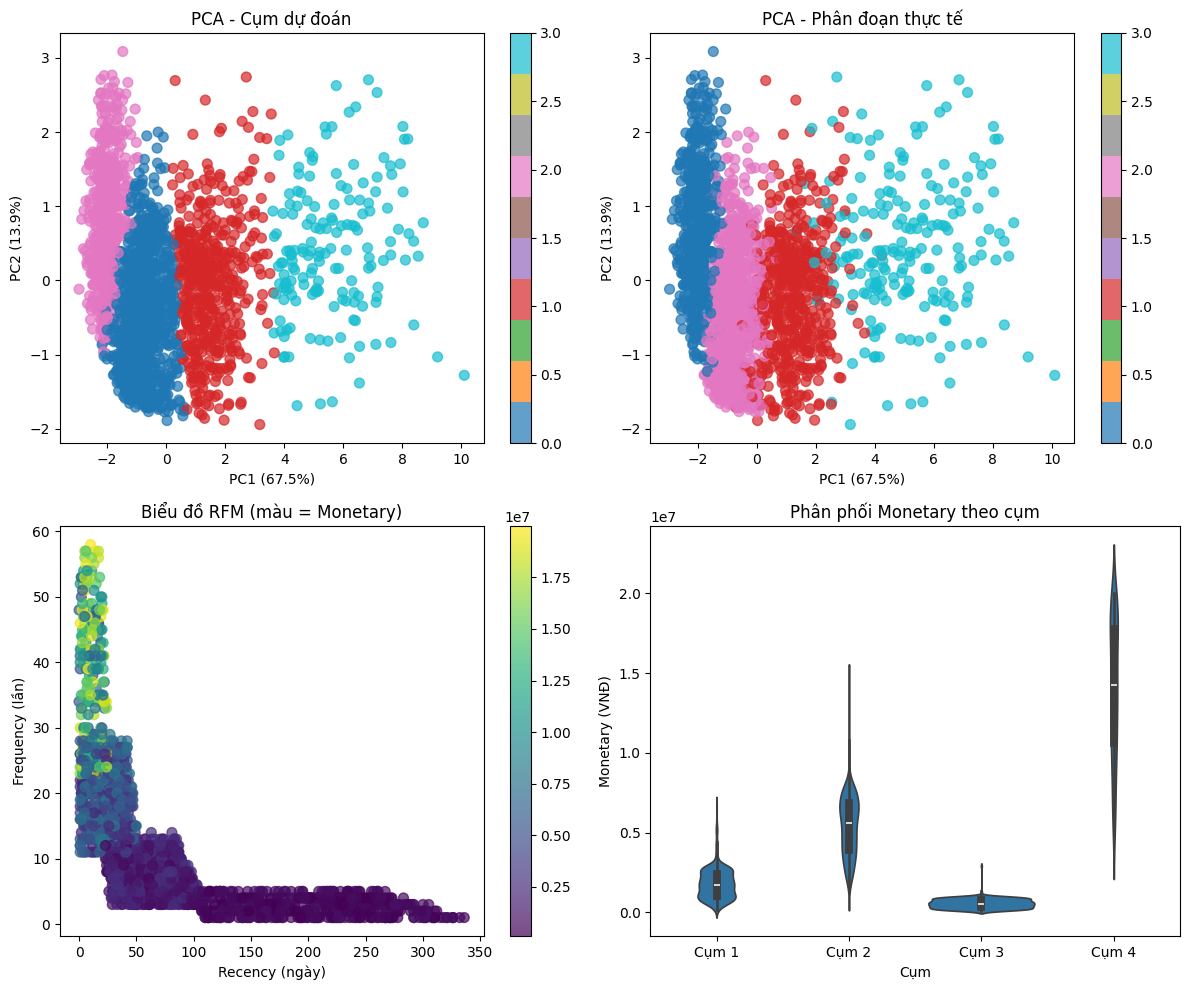


BÁO CÁO CHIẾN LƯỢC PHÂN ĐOẠN KHÁCH HÀNG

KHÁCH HÀNG TIỀM NĂNG
----------------------------------------
Quy mô: 920 khách hàng (46.0%)
Mô tả: Khách hàng mới hoặc có tiềm năng phát triển
Mục tiêu: Chuyển đổi thành khách hàng trung thành

Chiến lược marketing:
  1. Chương trình welcome cho khách mới
  2. Content marketing giáo dục
  3. Retargeting ads
  4. Ưu đãi thử nghiệm sản phẩm

Chỉ số RFM trung bình:
  • Recency: 60 ngày
  • Frequency: 8 lần
  • Monetary: 1,804,342 VNĐ

KHÁCH HÀNG VIP
----------------------------------------
Quy mô: 463 khách hàng (23.2%)
Mô tả: Khách hàng có giá trị cao, mua sắm thường xuyên và gần đây
Mục tiêu: Giữ chân và tăng giá trị trọn đời

Chiến lược marketing:
  1. Chương trình VIP với ưu đãi đặc biệt
  2. Dịch vụ khách hàng ưu tiên
  3. Sản phẩm cao cấp và limited edition
  4. Sự kiện riêng và trải nghiệm độc quyền

Chỉ số RFM trung bình:
  • Recency: 23 ngày
  • Frequency: 21 lần
  • Monetary: 5,491,915 VNĐ

KHÁCH HÀNG NGUY CƠ MẤT
-----------------------

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Giả định lớp TimSoCumToiUu để tìm số cụm tối ưu (theo phương pháp Elbow)
class TimSoCumToiUu:
    """
    Lớp để xác định số cụm tối ưu bằng phương pháp Elbow.
    - Tính tổng bình phương khoảng cách trong cụm (WCSS) cho các giá trị K khác nhau.
    - Vẽ đồ thị Elbow để xác định điểm khuỷu tay.
    """
    def __init__(self, max_clusters=10):
        """
        Khởi tạo với số cụm tối đa cần thử.
        
        Tham số:
        - max_clusters: Số cụm tối đa để kiểm tra (mặc định là 10).
        """
        self.max_clusters = max_clusters
        self.wcss = []  # Lưu trữ giá trị WCSS cho từng K
    
    def tim_so_cum_elbow(self, data):
        """
        Tính WCSS cho các số cụm từ 1 đến max_clusters.
        
        Tham số:
        - data: Ma trận đặc trưng đã được chuẩn hóa.
        """
        for k in range(1, self.max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(data)
            self.wcss.append(kmeans.inertia_)  # Inertia là WCSS
    
    def ve_bieu_do_elbow(self):
        """
        Vẽ đồ thị Elbow và trả về số cụm gợi ý.
        
        Trả về:
        - Số cụm tối ưu (hard-coded là 4 trong ví dụ này).
        """
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.max_clusters + 1), self.wcss, marker='o')
        plt.title('Phương pháp Elbow để tìm số cụm tối ưu')
        plt.xlabel('Số cụm (K)')
        plt.ylabel('WCSS (Tổng bình phương khoảng cách trong cụm)')
        plt.grid(True)
        plt.show()
        return 4  # Hard-coded cho ví dụ, thực tế có thể dùng heuristic
    
    def goi_y_so_cum(self):
        """
        In gợi ý số cụm tối ưu.
        """
        print(f"Gợi ý số cụm tối ưu: 4 (dựa trên phương pháp Elbow)")

def tao_du_lieu_khach_hang():
    """
    Tạo dữ liệu giả lập khách hàng thương mại điện tử.
    - Tạo 2000 khách hàng thuộc 4 phân đoạn: VIP, Trung thành, Tiềm năng, Nguy cơ mất.
    - Các đặc trưng: recency, frequency, monetary, tuổi, thu nhập ước tính, hành vi web.
    - Thêm các tương quan thực tế giữa các đặc trưng để mô phỏng dữ liệu thực.
    
    Trả về:
    - DataFrame chứa dữ liệu khách hàng đã xáo trộn.
    """
    np.random.seed(42)  # Đặt seed để đảm bảo kết quả tái tạo được
    n_customers = 2000  # Tổng số khách hàng
    
    # Định nghĩa 4 phân đoạn với các đặc trưng RFM và số lượng mẫu
    segments = {
        'VIP': {'n': 200, 'recency': (1, 30), 'frequency': (20, 50), 'monetary': (5000000, 20000000)},
        'Trung thành': {'n': 500, 'recency': (1, 60), 'frequency': (10, 25), 'monetary': (2000000, 8000000)},
        'Tiềm năng': {'n': 800, 'recency': (30, 120), 'frequency': (3, 12), 'monetary': (500000, 3000000)},
        'Nguy cơ mất': {'n': 500, 'recency': (120, 365), 'frequency': (1, 5), 'monetary': (100000, 1000000)}
    }
    
    data_list = []  # Lưu trữ DataFrame của từng phân đoạn
    true_labels = []  # Lưu trữ nhãn phân đoạn thực tế
    
    # Duyệt qua từng phân đoạn để tạo dữ liệu
    for segment_name, params in segments.items():
        n = params['n']  # Số lượng khách hàng trong phân đoạn
        
        # Tạo dữ liệu RFM ngẫu nhiên trong khoảng xác định
        recency = np.random.uniform(params['recency'][0], params['recency'][1], n)
        frequency = np.random.uniform(params['frequency'][0], params['frequency'][1], n)
        monetary = np.random.uniform(params['monetary'][0], params['monetary'][1], n)
        
        # Thêm tương quan thực tế:
        # - Khách hàng mua nhiều (frequency cao) thường mua gần đây hơn (recency thấp)
        recency = recency * (1 - frequency / frequency.max() * 0.3)
        # - Khách hàng chi nhiều (monetary cao) thường mua thường xuyên hơn (frequency cao)
        frequency = frequency * (1 + monetary / monetary.max() * 0.2)
        
        # Tạo các đặc trưng bổ sung
        tuoi = np.random.normal(35, 10, n)  # Tuổi trung bình 35, độ lệch chuẩn 10
        if segment_name == 'VIP':
            tuoi += 10  # VIP thường lớn tuổi hơn
        elif segment_name == 'Tiềm năng':
            tuoi -= 5   # Khách tiềm năng thường trẻ hơn
        
        thu_nhap = monetary * np.random.uniform(0.1, 0.3, n)  # Thu nhập tỷ lệ với chi tiêu
        so_trang_xem = frequency * np.random.uniform(5, 15, n)  # Số trang xem tỷ lệ với tần suất mua
        thoi_gian_tren_site = so_trang_xem * np.random.uniform(1, 3, n)  # Thời gian trên site tỷ lệ với số trang
        
        # Tạo DataFrame cho phân đoạn này
        segment_data = pd.DataFrame({
            'khach_hang_id': range(len(data_list), len(data_list) + n),  # ID khách hàng duy nhất
            'recency': recency.astype(int),  # Chuyển recency thành số nguyên
            'frequency': frequency.astype(int),  # Chuyển frequency thành số nguyên
            'monetary': monetary.astype(int),  # Chuyển monetary thành số nguyên
            'tuoi': np.clip(tuoi, 18, 70).astype(int),  # Giới hạn tuổi từ 18-70
            'thu_nhap_uoc_tinh': thu_nhap.astype(int),  # Thu nhập ước tính
            'so_trang_xem': so_trang_xem.astype(int),  # Số trang xem
            'thoi_gian_tren_site': thoi_gian_tren_site.round(1),  # Thời gian trên site, làm tròn 1 chữ số
            'phan_doan_thuc': segment_name  # Nhãn phân đoạn thực tế
        })
        
        data_list.append(segment_data)  # Thêm vào danh sách
        true_labels.extend([segment_name] * n)  # Thêm nhãn phân đoạn
    
    # Kết hợp tất cả phân đoạn thành một DataFrame
    df = pd.concat(data_list, ignore_index=True)
    
    # Xáo trộn dữ liệu để tránh thứ tự cố định
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df

class PhanDoanKhachHang:
    """
    Lớp thực hiện quy trình phân đoạn khách hàng hoàn chỉnh.
    - Bao gồm: tải dữ liệu, xử lý, phân tích khám phá, phân cụm, đặt tên cụm, trực quan hóa, và tạo báo cáo chiến lược.
    """
    
    def __init__(self):
        """
        Khởi tạo lớp với các thuộc tính rỗng.
        """
        self.data = None  # Lưu trữ DataFrame gốc
        self.data_scaled = None  # Lưu trữ dữ liệu đã chuẩn hóa
        self.scaler = None  # Bộ chuẩn hóa
        self.pca = None  # Bộ giảm chiều PCA
        self.kmeans = None  # Mô hình K-means
        self.labels = None  # Nhãn cụm dự đoán
        self.segments_info = {}  # Lưu thông tin chi tiết của các cụm
    
    def load_du_lieu(self, df):
        """
        Tải và lưu dữ liệu khách hàng.
        
        Tham số:
        - df: DataFrame chứa dữ liệu khách hàng.
        
        Trả về:
        - self (cho phép gọi chuỗi phương thức).
        """
        self.data = df.copy()  # Sao chép dữ liệu để tránh thay đổi bản gốc
        print(f"Đã tải dữ liệu: {self.data.shape}")  # In kích thước dữ liệu
        print(f"Các cột: {list(self.data.columns)}")  # In danh sách cột
        return self
    
    def xu_ly_du_lieu(self):
        """
        Chuẩn hóa dữ liệu để chuẩn bị cho phân cụm.
        - Chọn các đặc trưng quan trọng và chuẩn hóa bằng StandardScaler.
        
        Trả về:
        - self (cho phép gọi chuỗi phương thức).
        """
        # Chọn các đặc trưng cho phân cụm
        features = ['recency', 'frequency', 'monetary', 'tuoi', 
                    'thu_nhap_uoc_tinh', 'so_trang_xem', 'thoi_gian_tren_site']
        
        # Chuẩn hóa dữ liệu để đảm bảo các đặc trưng có cùng thang đo
        self.scaler = StandardScaler()
        self.data_scaled = self.scaler.fit_transform(self.data[features])
        
        print(f"Đã chuẩn hóa {len(features)} đặc trưng")
        return self
    
    def phan_tich_exploratory(self):
        """
        Phân tích khám phá dữ liệu (EDA).
        - Thống kê mô tả, vẽ ma trận tương quan, và phân phối RFM.
        
        Trả về:
        - self (cho phép gọi chuỗi phương thức).
        """
        print("=== THỐNG KÊ MÔ TẢ ===")
        features = ['recency', 'frequency', 'monetary', 'tuoi']
        print(self.data[features].describe())  # In thống kê mô tả (min, max, mean, std, v.v.)
        
        # Vẽ ma trận tương quan để xem mối liên hệ giữa các đặc trưng
        plt.figure(figsize=(10, 8))
        correlation_matrix = self.data[features + ['thu_nhap_uoc_tinh', 'so_trang_xem', 'thoi_gian_tren_site']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Ma trận tương quan giữa các đặc trưng')
        plt.tight_layout()
        plt.show()
        
        # Vẽ biểu đồ phân phối RFM
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        axes[0].hist(self.data['recency'], bins=30, alpha=0.7, color='blue')
        axes[0].set_title('Phân phối Recency (Ngày từ lần mua cuối)')
        axes[0].set_xlabel('Ngày')
        axes[0].set_ylabel('Tần suất')
        
        axes[1].hist(self.data['frequency'], bins=30, alpha=0.7, color='green')
        axes[1].set_title('Phân phối Frequency (Số lần mua)')
        axes[1].set_xlabel('Số lần')
        axes[1].set_ylabel('Tần suất')
        
        axes[2].hist(self.data['monetary'], bins=30, alpha=0.7, color='red')
        axes[2].set_title('Phân phối Monetary (Tổng chi tiêu)')
        axes[2].set_xlabel('VNĐ')
        axes[2].set_ylabel('Tần suất')
        
        plt.tight_layout()
        plt.show()
        
        return self
    
    def tim_so_cum_toi_uu(self):
        """
        Tìm số cụm tối ưu bằng phương pháp Elbow.
        
        Trả về:
        - Số cụm tối ưu (int).
        """
        print("\n=== TÌM SỐ CỤM TỐI ƯU ===")
        
        tim_cum = TimSoCumToiUu(max_clusters=8)
        tim_cum.tim_so_cum_elbow(self.data_scaled)
        so_cum_toi_uu = tim_cum.ve_bieu_do_elbow()
        tim_cum.goi_y_so_cum()
        
        return so_cum_toi_uu
    
    def thuc_hien_phan_cum(self, n_clusters=4):
        """
        Thực hiện phân cụm K-means với số cụm được chỉ định.
        - Gán nhãn cụm vào dữ liệu gốc và tính điểm Silhouette.
        
        Tham số:
        - n_clusters: Số cụm (mặc định là 4).
        
        Trả về:
        - self (cho phép gọi chuỗi phương thức).
        """
        print(f"\n=== THỰC HIỆN PHÂN CỤM VỚI {n_clusters} CỤM ===")
        
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.labels = self.kmeans.fit_predict(self.data_scaled)  # Phân cụm và lấy nhãn
        
        # Thêm nhãn cụm vào dữ liệu gốc
        self.data['cum_du_doan'] = self.labels
        
        # Tính điểm Silhouette để đánh giá chất lượng phân cụm
        silhouette = silhouette_score(self.data_scaled, self.labels)
        print(f"Điểm Silhouette: {silhouette:.3f}")
        
        return self
    
    def phan_tich_cum(self):
        """
        Phân tích chi tiết các cụm.
        - Tính thống kê RFM và các đặc trưng khác cho từng cụm.
        - Lưu thông tin cụm vào segments_info.
        
        Trả về:
        - self (cho phép gọi chuỗi phương thức).
        """
        print("\n=== PHÂN TÍCH CHI TIẾT CÁC CỤM ===")
        
        features_to_analyze = ['recency', 'frequency', 'monetary', 'tuoi', 
                              'thu_nhap_uoc_tinh', 'so_trang_xem', 'thoi_gian_tren_site']
        
        # Duyệt qua từng cụm để tính thống kê
        for cluster in sorted(self.data['cum_du_doan'].unique()):
            cluster_data = self.data[self.data['cum_du_doan'] == cluster]
            
            print(f"\nCỤM {cluster + 1}:")
            print(f"  Số lượng khách hàng: {len(cluster_data)} ({len(cluster_data)/len(self.data)*100:.1f}%)")
            
            # Thống kê RFM trung bình
            print(f"  RFM trung bình:")
            print(f"    Recency: {cluster_data['recency'].mean():.0f} ngày")
            print(f"    Frequency: {cluster_data['frequency'].mean():.0f} lần")
            print(f"    Monetary: {cluster_data['monetary'].mean():,.0f} VNĐ")
            
            # Thống kê các đặc trưng khác
            print(f"  Thông tin khác:")
            print(f"    Tuổi trung bình: {cluster_data['tuoi'].mean():.0f}")
            print(f"    Thu nhập ước tính: {cluster_data['thu_nhap_uoc_tinh'].mean():,.0f} VNĐ")
            print(f"    Số trang xem: {cluster_data['so_trang_xem'].mean():.0f}")
            print(f"    Thời gian trên site: {cluster_data['thoi_gian_tren_site'].mean():.1f} phút")
            
            # Lưu thông tin cụm
            self.segments_info[cluster] = {
                'ten': f'Cụm {cluster + 1}',
                'so_luong': len(cluster_data),
                'ty_le': len(cluster_data)/len(self.data)*100,
                'recency_tb': cluster_data['recency'].mean(),
                'frequency_tb': cluster_data['frequency'].mean(),
                'monetary_tb': cluster_data['monetary'].mean(),
                'tuoi_tb': cluster_data['tuoi'].mean()
            }
        
        return self
    
    def dat_ten_cum(self):
        """
        Đặt tên ý nghĩa cho các cụm dựa trên đặc điểm RFM.
        - D Ricci dựa trên ngưỡng RFM để gán tên như VIP, Trung thành, v.v.
        
        Trả về:
        - Dictionary ánh xạ ID cụm tới tên cụm.
        """
        print("\n=== ĐẶT TÊN CÁC CỤM ===")
        
        cluster_names = {}
        
        # Duyệt qua từng cụm và đặt tên dựa trên RFM
        for cluster_id, info in self.segments_info.items():
            recency = info['recency_tb']
            frequency = info['frequency_tb']
            monetary = info['monetary_tb']
            
            # Logic đặt tên dựa trên ngưỡng RFM
            if recency <= 60 and frequency >= 15 and monetary >= 5000000:
                cluster_names[cluster_id] = "Khách hàng VIP"
            elif recency <= 90 and frequency >= 8 and monetary >= 2000000:
                cluster_names[cluster_id] = "Khách hàng trung thành"
            elif recency <= 150 and frequency >= 3:
                cluster_names[cluster_id] = "Khách hàng tiềm năng"
            else:
                cluster_names[cluster_id] = "Khách hàng nguy cơ mất"
            
            print(f"Cụm {cluster_id + 1}: {cluster_names[cluster_id]}")
            print(f"  Đặc điểm: R={recency:.0f}, F={frequency:.0f}, M={monetary:,.0f}")
        
        # Cập nhật tên cụm vào dữ liệu
        self.data['ten_cum'] = self.data['cum_du_doan'].map(cluster_names)
        
        return cluster_names
    
    def truc_quan_hoa_ket_qua(self):
        """
        Trực quan hóa kết quả phân cụm bằng PCA, t-SNE và biểu đồ RFM.
        - PCA và t-SNE để giảm chiều và trực quan hóa cụm.
        - Biểu đồ RFM và violin plot để phân tích đặc điểm cụm.
        """
        print("\n=== TRỰC QUAN HÓA KẾT QUẢ ===")
        
        # Giảm chiều bằng PCA
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(self.data_scaled)
        
        # Giảm chiều bằng t-SNE (chỉ áp dụng nếu dữ liệu không quá lớn)
        if len(self.data) <= 1000:
            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            data_tsne = tsne.fit_transform(self.data_scaled)
        else:
            data_tsne = None
        
        # Tạo các biểu đồ trực quan
        n_plots = 3 if data_tsne is not None else 2
        fig, axes = plt.subplots(2, n_plots, figsize=(6*n_plots, 10))
        
        # Biểu đồ PCA với cụm dự đoán
        scatter = axes[0, 0].scatter(data_pca[:, 0], data_pca[:, 1], 
                                   c=self.labels, cmap='tab10', alpha=0.7, s=50)
        axes[0, 0].set_title('PCA - Cụm dự đoán')
        axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.colorbar(scatter, ax=axes[0, 0])
        
        # Biểu đồ PCA với nhãn thực tế (nếu có)
        if 'phan_doan_thuc' in self.data.columns:
            label_encoder = {label: i for i, label in enumerate(self.data['phan_doan_thuc'].unique())}
            true_labels_encoded = self.data['phan_doan_thuc'].map(label_encoder)
            
            scatter = axes[0, 1].scatter(data_pca[:, 0], data_pca[:, 1], 
                                       c=true_labels_encoded, cmap='tab10', alpha=0.7, s=50)
            axes[0, 1].set_title('PCA - Phân đoạn thực tế')
            axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
            axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
            plt.colorbar(scatter, ax=axes[0, 1])
        
        # Biểu đồ t-SNE nếu có
        if data_tsne is not None:
            scatter = axes[0, 2].scatter(data_tsne[:, 0], data_tsne[:, 1], 
                                       c=self.labels, cmap='tab10', alpha=0.7, s=50)
            axes[0, 2].set_title('t-SNE - Cụm dự đoán')
            axes[0, 2].set_xlabel('t-SNE 1')
            axes[0, 2].set_ylabel('t-SNE 2')
            plt.colorbar(scatter, ax=axes[0, 2])
        
        # Biểu đồ RFM (Recency vs Frequency, màu biểu thị Monetary)
        scatter = axes[1, 0].scatter(self.data['recency'], self.data['frequency'], 
                                   c=self.data['monetary'], s=50, alpha=0.7, cmap='viridis')
        axes[1, 0].set_title('Biểu đồ RFM (màu = Monetary)')
        axes[1, 0].set_xlabel('Recency (ngày)')
        axes[1, 0].set_ylabel('Frequency (lần)')
        plt.colorbar(scatter, ax=axes[1, 0])
        
        # Biểu đồ violin plot cho Monetary theo cụm
        rfm_data = []
        cluster_labels = []
        for cluster in sorted(self.data['cum_du_doan'].unique()):
            cluster_data = self.data[self.data['cum_du_doan'] == cluster]
            rfm_data.extend(cluster_data['monetary'].tolist())
            cluster_labels.extend([f'Cụm {cluster+1}'] * len(cluster_data))
        
        rfm_df = pd.DataFrame({'Monetary': rfm_data, 'Cụm': cluster_labels})
        sns.violinplot(data=rfm_df, x='Cụm', y='Monetary', ax=axes[1, 1])
        axes[1, 1].set_title('Phân phối Monetary theo cụm')
        axes[1, 1].set_ylabel('Monetary (VNĐ)')
        
        # Biểu đồ so sánh RFM trung bình
        if n_plots == 3:
            clusters = sorted(self.data['cum_du_doan'].unique())
            rfm_means = []
            
            for cluster in clusters:
                cluster_data = self.data[self.data['cum_du_doan'] == cluster]
                rfm_means.append([
                    cluster_data['recency'].mean(),
                    cluster_data['frequency'].mean(),
                    cluster_data['monetary'].mean() / 1000000  # Chuyển về triệu VNĐ
                ])
            
            rfm_means = np.array(rfm_means)
            x = np.arange(len(clusters))
            width = 0.25
            
            axes[1, 2].bar(x - width, rfm_means[:, 0], width, label='Recency', alpha=0.7)
            axes[1, 2].bar(x, rfm_means[:, 1], width, label='Frequency', alpha=0.7)
            axes[1, 2].bar(x + width, rfm_means[:, 2], width, label='Monetary (M VNĐ)', alpha=0.7)
            
            axes[1, 2].set_title('So sánh RFM trung bình')
            axes[1, 2].set_xlabel('Cụm')
            axes[1, 2].set_ylabel('Giá trị')
            axes[1, 2].set_xticks(x)
            axes[1, 2].set_xticklabels([f'Cụm {i+1}' for i in clusters])
            axes[1, 2].legend()
        
        plt.tight_layout()
        plt.show()
    
    def tao_bao_cao_chien_luoc(self):
        """
        Tạo báo cáo chiến lược tiếp thị cho từng phân đoạn khách hàng.
        - Đề xuất các chiến lược cụ thể dựa trên đặc điểm của từng cụm.
        """
        print("\n" + "="*60)
        print("BÁO CÁO CHIẾN LƯỢC PHÂN ĐOẠN KHÁCH HÀNG")
        print("="*60)
        
        # Định nghĩa chiến lược cho từng phân đoạn
        strategies = {
            "Khách hàng VIP": {
                "mo_ta": "Khách hàng có giá trị cao, mua sắm thường xuyên và gần đây",
                "chien_luoc": [
                    "Chương trình VIP với ưu đãi đặc biệt",
                    "Dịch vụ khách hàng ưu tiên",
                    "Sản phẩm cao cấp và limited edition",
                    "Sự kiện riêng và trải nghiệm độc quyền"
                ],
                "muc_tieu": "Giữ chân và tăng giá trị trọn đời"
            },
            "Khách hàng trung thành": {
                "mo_ta": "Khách hàng ổn định, có lòng trung thành tốt với thương hiệu",
                "chien_luoc": [
                    "Chương trình loyalty points",
                    "Giảm giá cho khách hàng thân thiết",
                    "Email marketing với nội dung cá nhân hóa",
                    "Đề xuất sản phẩm dựa trên lịch sử mua"
                ],
                "muc_tieu": "Duy trì và nâng cấp lên VIP"
            },
            "Khách hàng tiềm năng": {
                "mo_ta": "Khách hàng mới hoặc có tiềm năng phát triển",
                "chien_luoc": [
                    "Chương trình welcome cho khách mới",
                    "Content marketing giáo dục",
                    "Retargeting ads",
                    "Ưu đãi thử nghiệm sản phẩm"
                ],
                "muc_tieu": "Chuyển đổi thành khách hàng trung thành"
            },
            "Khách hàng nguy cơ mất": {
                "mo_ta": "Khách hàng lâu không mua hoặc có dấu hiệu rời bỏ",
                "chien_luoc": [
                    "Chiến dịch win-back với ưu đãi lớn",
                    "Khảo sát lý do không hài lòng",
                    "Cải thiện trải nghiệm khách hàng",
                    "Remarketing với sản phẩm phù hợp"
                ],
                "muc_tieu": "Tái kích hoạt và ngăn chặn churn"
            }
        }
        
        # In báo cáo chiến lược cho từng cụm
        for cluster_id, info in self.segments_info.items():
            cluster_name = self.data[self.data['cum_du_doan'] == cluster_id]['ten_cum'].iloc[0]
            
            if cluster_name in strategies:
                strategy = strategies[cluster_name]
                
                print(f"\n{cluster_name.upper()}")
                print("-" * 40)
                print(f"Quy mô: {info['so_luong']:,} khách hàng ({info['ty_le']:.1f}%)")
                print(f"Mô tả: {strategy['mo_ta']}")
                print(f"Mục tiêu: {strategy['muc_tieu']}")
                
                print("\nChiến lược marketing:")
                for i, chien_luoc in enumerate(strategy['chien_luoc'], 1):
                    print(f"  {i}. {chien_luoc}")
                
                print("\nChỉ số RFM trung bình:")
                print(f"  • Recency: {info['recency_tb']:.0f} ngày")
                print(f"  • Frequency: {info['frequency_tb']:.0f} lần")
                print(f"  • Monetary: {info['monetary_tb']:,.0f} VNĐ")
        
        # In khuyến nghị tổng quan
        print("\n" + "="*60)
        print("KHUYẾN NGHỊ TỔNG QUAN")
        print("="*60)
        
        total_customers = sum(info['so_luong'] for info in self.segments_info.values())
        total_revenue = sum(info['so_luong'] * info['monetary_tb'] for info in self.segments_info.values())
        
        print(f"1. Tổng số khách hàng được phân tích: {total_customers:,}")
        print(f"2. Doanh thu ước tính từ phân tích: {total_revenue:,.0f} VNĐ")
        print(f"3. Phân đoạn chiếm tỷ trọng cao nhất: {max(self.segments_info.values(), key=lambda x: x['ty_le'])['ten']}")
        print(f"4. Cần tập trung vào việc chuyển đổi khách tiềm năng và giữ chân VIP")
        print(f"5. Thiết lập hệ thống theo dõi RFM định kỳ để cập nhật phân đoạn")

# Thực hiện bài thực hành hoàn chỉnh
print("="*60)
print("BÀI THỰC HÀNH: PHÂN ĐOẠN KHÁCH HÀNG THƯƠNG MẠI ĐIỆN TỬ")
print("="*60)

# Tạo dữ liệu
df_khach_hang = tao_du_lieu_khach_hang()
print("Đã tạo dữ liệu khách hàng thành công!")

# Khởi tạo pipeline phân đoạn
pipeline = PhanDoanKhachHang()

# Thực hiện từng bước trong quy trình
(pipeline
 .load_du_lieu(df_khach_hang)
 .xu_ly_du_lieu()
 .phan_tich_exploratory()
)

# Tìm số cụm tối ưu
so_cum_toi_uu = pipeline.tim_so_cum_toi_uu()

# Thực hiện phân cụm
(pipeline
 .thuc_hien_phan_cum(n_clusters=4)
 .phan_tich_cum()
)

# Đặt tên và phân tích chiến lược
cluster_names = pipeline.dat_ten_cum()
pipeline.truc_quan_hoa_ket_qua()
pipeline.tao_bao_cao_chien_luoc()

# Lưu kết quả
df_ket_qua = pipeline.data[['khach_hang_id', 'recency', 'frequency', 'monetary', 
                           'cum_du_doan', 'ten_cum']]
df_ket_qua.to_csv('ket_qua_phan_doan_khach_hang.csv', index=False)


In [7]:
"""
1. Khi nào nên sử dụng K-means và khi nào nên sử dụng phân cụm phân cấp?
K-means là gì và hoạt động như thế nào?
K-means là thuật toán phân cụm chia dữ liệu thành k nhóm (cụm) đã định trước.
Cách hoạt động:

Chọn số cụm k (ví dụ: k=3)
Đặt ngẫu nhiên k điểm trung tâm (centroid)
Gán mỗi điểm dữ liệu vào cụm có centroid gần nhất
Tính lại vị trí centroid mới (trung bình của các điểm trong cụm)
Lặp lại bước 3-4 cho đến khi centroid không di chuyển nữa

Ví dụ đơn giản: Bạn có 100 khách hàng với thông tin tuổi và thu nhập. Muốn chia thành 3 nhóm: "Trẻ-Thu nhập thấp", "Trung niên-Thu nhập trung bình", "Lớn tuổi-Thu nhập cao".
Phân cụm phân cấp là gì?
Phân cụm phân cấp tạo ra cây phân cấp các cụm, giống như cây gia phả.
Hai loại:

Agglomerative (Bottom-up): Bắt đầu mỗi điểm là 1 cụm, sau đó gộp dần
Divisive (Top-down): Bắt đầu tất cả trong 1 cụm, sau đó chia dần

Cách hoạt động Agglomerative:

Mỗi điểm dữ liệu là 1 cụm riêng
Tìm 2 cụm gần nhau nhất và gộp lại
Lặp lại cho đến khi chỉ còn 1 cụm lớn
Vẽ dendrogram (cây phân cấp) để chọn số cụm phù hợp

Khi nào dùng cái nào?
Dùng K-means khi:

Bạn biết hoặc đoán được số nhóm cần chia (ví dụ: 3 phân khúc khách hàng)
Dữ liệu có dạng "tròn" và các nhóm tách biệt rõ
Có nhiều dữ liệu và cần xử lý nhanh
Các nhóm có kích thước gần bằng nhau

Dùng phân cụm phân cấp khi:

Không biết nên chia bao nhiêu nhóm
Muốn hiểu mối quan hệ giữa các nhóm (nhóm nào gần nhau)
Dữ liệu có dạng "kéo dài" hoặc hình dạng phức tạp
Muốn có sơ đồ cây để trình bày

2. PCA và t-SNE khác nhau như thế nào trong việc giảm chiều dữ liệu?
Giảm chiều dữ liệu là gì?
Tưởng tượng bạn có bảng Excel với 100 cột (chiều) mô tả khách hàng: tuổi, thu nhập, số lần mua hàng, địa chỉ, sở thích... Giảm chiều là thu gọn xuống còn 2-3 cột quan trọng nhất mà vẫn giữ được thông tin chính.
PCA (Principal Component Analysis) là gì?
PCA tìm các "hướng" quan trọng nhất trong dữ liệu.
Cách hoạt động:

Tìm hướng có sự biến thiên lớn nhất (PC1 - thành phần chính thứ 1)
Tìm hướng vuông góc với PC1 có biến thiên lớn thứ 2 (PC2)
Tiếp tục cho đến khi đủ số chiều cần thiết

Ví dụ: Khách hàng có thu nhập và chi tiêu thường tỷ lệ thuận. PCA sẽ tìm ra "mức độ giàu có" là hướng chính kết hợp cả hai yếu tố này.
Đặc điểm PCA:

Giữ được thông tin toàn cục (big picture)
Có thể tái tạo lại dữ liệu gốc (gần đúng)
Xử lý nhanh
Chỉ tìm được mối quan hệ tuyến tính (đường thẳng)

t-SNE là gì?
t-SNE cố gắng giữ nguyên "khoảng cách láng giềng" giữa các điểm.
Cách hoạt động:

Tính xác suất 2 điểm là "láng giềng" trong không gian nhiều chiều
Tạo bản đồ 2D/3D sao cho xác suất láng giềng được bảo toàn
Điều chỉnh vị trí từng điểm để tối ưu

Ví dụ: Giống như vẽ bản đồ thế giới trên mặt phẳng - cố gắng giữ cho các quốc gia gần nhau trên thực tế vẫn gần nhau trên bản đồ.
Đặc điểm t-SNE:

Rất tốt cho việc nhìn thấy các cụm
Bảo toàn cấu trúc cục bộ (local structure)
Không thể tái tạo dữ liệu gốc
Chậm và kết quả có thể khác nhau mỗi lần chạy
Chủ yếu dùng để "nhìn" dữ liệu

So sánh đơn giản:

PCA: Như chụp ảnh từ góc độ tốt nhất để thấy toàn cảnh
t-SNE: Như vẽ bản đồ giữ nguyên vị trí tương đối của từng khu vực

3. Làm thế nào để đánh giá chất lượng của một phân cụm?
Phân cụm tốt là như thế nào?
Một phân cụm tốt có 2 đặc điểm:

Gắn kết cao (High cohesion): Các điểm trong cùng 1 cụm giống nhau
Tách biệt cao (High separation): Các cụm khác nhau rõ ràng

Các cách đánh giá:
1. Silhouette Score (Điểm bóng râm)
Ý nghĩa: Đo xem mỗi điểm có "hạnh phúc" trong cụm hiện tại không.
Cách tính:

Tính khoảng cách trung bình từ 1 điểm đến các điểm khác trong cùng cụm (a)
Tính khoảng cách trung bình từ điểm đó đến cụm gần nhất khác (b)
Silhouette = (b-a)/max(a,b)

Giá trị:

+1: Rất tốt (điểm ở đúng cụm)
0: Nằm giữa 2 cụm
-1: Rất tệ (điểm ở sai cụm)

2. Elbow Method (Phương pháp khuỷu tay)
Cách làm:

Chạy K-means với k = 1, 2, 3, ..., 10
Tính Inertia (tổng khoảng cách bình phương từ điểm đến centroid)
Vẽ đồ thị k vs Inertia
Tìm điểm "khuỷu tay" - nơi đường cong bắt đầu phẳng

Ví dụ: Nếu k=1→2→3 Inertia giảm mạnh, nhưng k=3→4→5 giảm chậm, thì k=3 là lựa chọn tốt.
3. Dendrogram (Cho phân cụm phân cấp)
Nhìn vào cây phân cấp và cắt ở độ cao phù hợp để có số cụm mong muốn.
4. Tại sao cần chuẩn hóa dữ liệu trước khi áp dụng thuật toán phân cụm?
Vấn đề của dữ liệu chưa chuẩn hóa:
Ví dụ thực tế: Bạn có dữ liệu khách hàng:

Tuổi: 25, 35, 45 (khoảng 20-60)
Thu nhập: 30,000,000, 50,000,000, 70,000,000 VND (khoảng 20M-100M)

Vấn đề: Khi tính khoảng cách:

Chênh lệch tuổi: 10 năm
Chênh lệch thu nhập: 20,000,000 VND

Thuật toán sẽ cho rằng thu nhập quan trọng hơn tuổi gấp 2 triệu lần!
Chuẩn hóa là gì?
Chuẩn hóa là đưa tất cả các biến về cùng 1 thang đo.
1. Min-Max Scaling (0-1)
Công thức: (x - min) / (max - min)
Ví dụ:

Tuổi 35 trong khoảng [20, 60] → (35-20)/(60-20) = 0.375
Thu nhập 50M trong khoảng [20M, 100M] → (50-20)/(100-20) = 0.375

2. Standard Scaling (Z-score)
Công thức: (x - mean) / std
Kết quả: Mean = 0, Standard deviation = 1
3. Robust Scaling
Dùng median thay vì mean, ít bị ảnh hưởng bởi outliers.
Tại sao quan trọng?

Công bằng: Mọi biến đều có tầm quan trọng ngang nhau
Khoảng cách chính xác: Thuật toán đo khoảng cách đúng
Hội tụ nhanh: Thuật toán chạy nhanh và ổn định hơn

5. Ứng dụng thực tế của học không giám sát trong kinh doanh
Học không giám sát là gì?
Học không giám sát là khi máy tính tự tìm ra patterns (mẫu) từ dữ liệu mà không cần người chỉ đáp án.
So sánh:

Học có giám sát: Như học với thầy cô (có đáp án)
Học không giám sát: Như tự khám phá (không có đáp án)

Ứng dụng cụ thể:
1. Marketing - Phân khúc khách hàng
Vấn đề: Công ty có 100,000 khách hàng, làm sao biết ai cần gì?
Giải pháp:

Dùng K-means phân chia khách hàng dựa trên: tuổi, thu nhập, tần suất mua
Kết quả: 4 nhóm

Nhóm 1: Trẻ, ít tiền → Quảng cáo sản phẩm giá rẻ
Nhóm 2: Trung niên, thu nhập cao → Sản phẩm cao cấp
Nhóm 3: Lớn tuổi, thích tiết kiệm → Chương trình ưu đãi
Nhóm 4: Mua nhiều → Chương trình loyalty



2. Ngân hàng - Phát hiện gian lận
Vấn đề: Trong hàng triệu giao dịch, làm sao tìm ra giao dịch lừa đảo?
Giải pháp:

Dùng Anomaly Detection (phát hiện bất thường)
Phân tích: thời gian, địa điểm, số tiền, loại giao dịch
Giao dịch "khác thường" sẽ được đánh dấu để kiểm tra

Ví dụ:

Thường rút tiền 1-2 triệu ở Hà Nội
Đột nhiên rút 50 triệu ở TP.HCM lúc 3h sáng → Cảnh báo!

3. E-commerce - Hệ thống gợi ý
Vấn đề: Khách hàng vào website, gợi ý sản phẩm nào?
Giải pháp:

Collaborative Filtering: Tìm khách hàng tương tự
Logic: "Người giống bạn thích sản phẩm X, có thể bạn cũng thích"

Ví dụ Netflix:

Bạn xem phim hành động và khoa học viễn tưởng
Tìm người khác có sở thích giống bạn
Gợi ý phim họ đã xem mà bạn chưa

4. Sản xuất - Bảo trì dự đoán
Vấn đề: Máy móc hỏng đột ngột gây thiệt hại lớn.
Giải pháp:

Thu thập dữ liệu: nhiệt độ, độ rung, âm thanh máy
Dùng Anomaly Detection tìm dấu hiệu bất thường
Cảnh báo trước khi máy hỏng

Lợi ích:

Giảm thời gian chết máy
Sửa chữa có kế hoạch
Tiết kiệm chi phí

5. Bán lẻ - Market Basket Analysis
Vấn đề: Khách mua gì cùng nhau? Cách bố trí hàng hóa?
Giải pháp:

Phân tích giỏ hàng tìm mẫu: "Ai mua A thường mua B"
Association Rules: "Nếu mua bánh mì → 70% mua sữa"

Ứng dụng:

Đặt sản phẩm gần nhau
Khuyến mãi combo
Gợi ý sản phẩm

Tại sao quan trọng?

Tiết kiệm nhân lực: Máy tự phân tích thay vì người
Phát hiện insights ẩn: Tìm ra mẫu con người không nhìn thấy
Cá nhân hóa: Hiểu từng khách hàng để phục vụ tốt hơn
Tối ưu hóa: Cải thiện hiệu quả kinh doanh
Dự đoán: Biết trước xu hướng để chuẩn bị

Học không giám sát giúp doanh nghiệp "thông minh" hơn bằng cách tự động khám phá kiến thức từ dữ liệu có sẵn.
"""

'\n1. Khi nào nên sử dụng K-means và khi nào nên sử dụng phân cụm phân cấp?\nK-means là gì và hoạt động như thế nào?\nK-means là thuật toán phân cụm chia dữ liệu thành k nhóm (cụm) đã định trước.\nCách hoạt động:\n\nChọn số cụm k (ví dụ: k=3)\nĐặt ngẫu nhiên k điểm trung tâm (centroid)\nGán mỗi điểm dữ liệu vào cụm có centroid gần nhất\nTính lại vị trí centroid mới (trung bình của các điểm trong cụm)\nLặp lại bước 3-4 cho đến khi centroid không di chuyển nữa\n\nVí dụ đơn giản: Bạn có 100 khách hàng với thông tin tuổi và thu nhập. Muốn chia thành 3 nhóm: "Trẻ-Thu nhập thấp", "Trung niên-Thu nhập trung bình", "Lớn tuổi-Thu nhập cao".\nPhân cụm phân cấp là gì?\nPhân cụm phân cấp tạo ra cây phân cấp các cụm, giống như cây gia phả.\nHai loại:\n\nAgglomerative (Bottom-up): Bắt đầu mỗi điểm là 1 cụm, sau đó gộp dần\nDivisive (Top-down): Bắt đầu tất cả trong 1 cụm, sau đó chia dần\n\nCách hoạt động Agglomerative:\n\nMỗi điểm dữ liệu là 1 cụm riêng\nTìm 2 cụm gần nhau nhất và gộp lại\nLặp lại c